## Package Installations and drive setup

In [1]:
import pandas as pd
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

import anndata2ri
import logging
import rpy2.rinterface_lib.callbacks as rcb
import rpy2.robjects as ro

rcb.logger.setLevel(logging.ERROR)
ro.pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython

/tmp/ipykernel_977381/1151448009.py:15: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [2]:
%%R
library(tidyverse)
library(dyno)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: dynfeature
Loading required package: dynguidelines
Loading required package: dynmethods
Loading required package: dynplot
Loading required package: dynwrap
In addition: Warning message:
In (function (package, help, pos = 2, lib.loc = NULL, character.only = FALSE,  :
  library ‘/usr/lib/R/site-library’ contains no packages


In [3]:
import scanpy
# import dca
# import magic-impute
# import louvain
import pygam
import phate
import phenograph

In [4]:
import palantir

In [5]:
import pyVIA

/home/satwik/dynooenv/lib/python3.12/site-packages/phate/__init__.py


## Preprocessing

In [6]:
%matplotlib inline
# %run main.py

In [7]:
import numpy as np
import scanpy as sc
import torch
import pandas as pd

random_seed = 0
np.random.seed(random_seed)
torch.manual_seed(random_seed)

In [8]:
# Load data
data_path = 'oligodendrocyte-differentiation-subclusters_marques.h5ad'
adata = sc.read(data_path)

In [9]:
adata.to_df().shape

(4930, 3534)

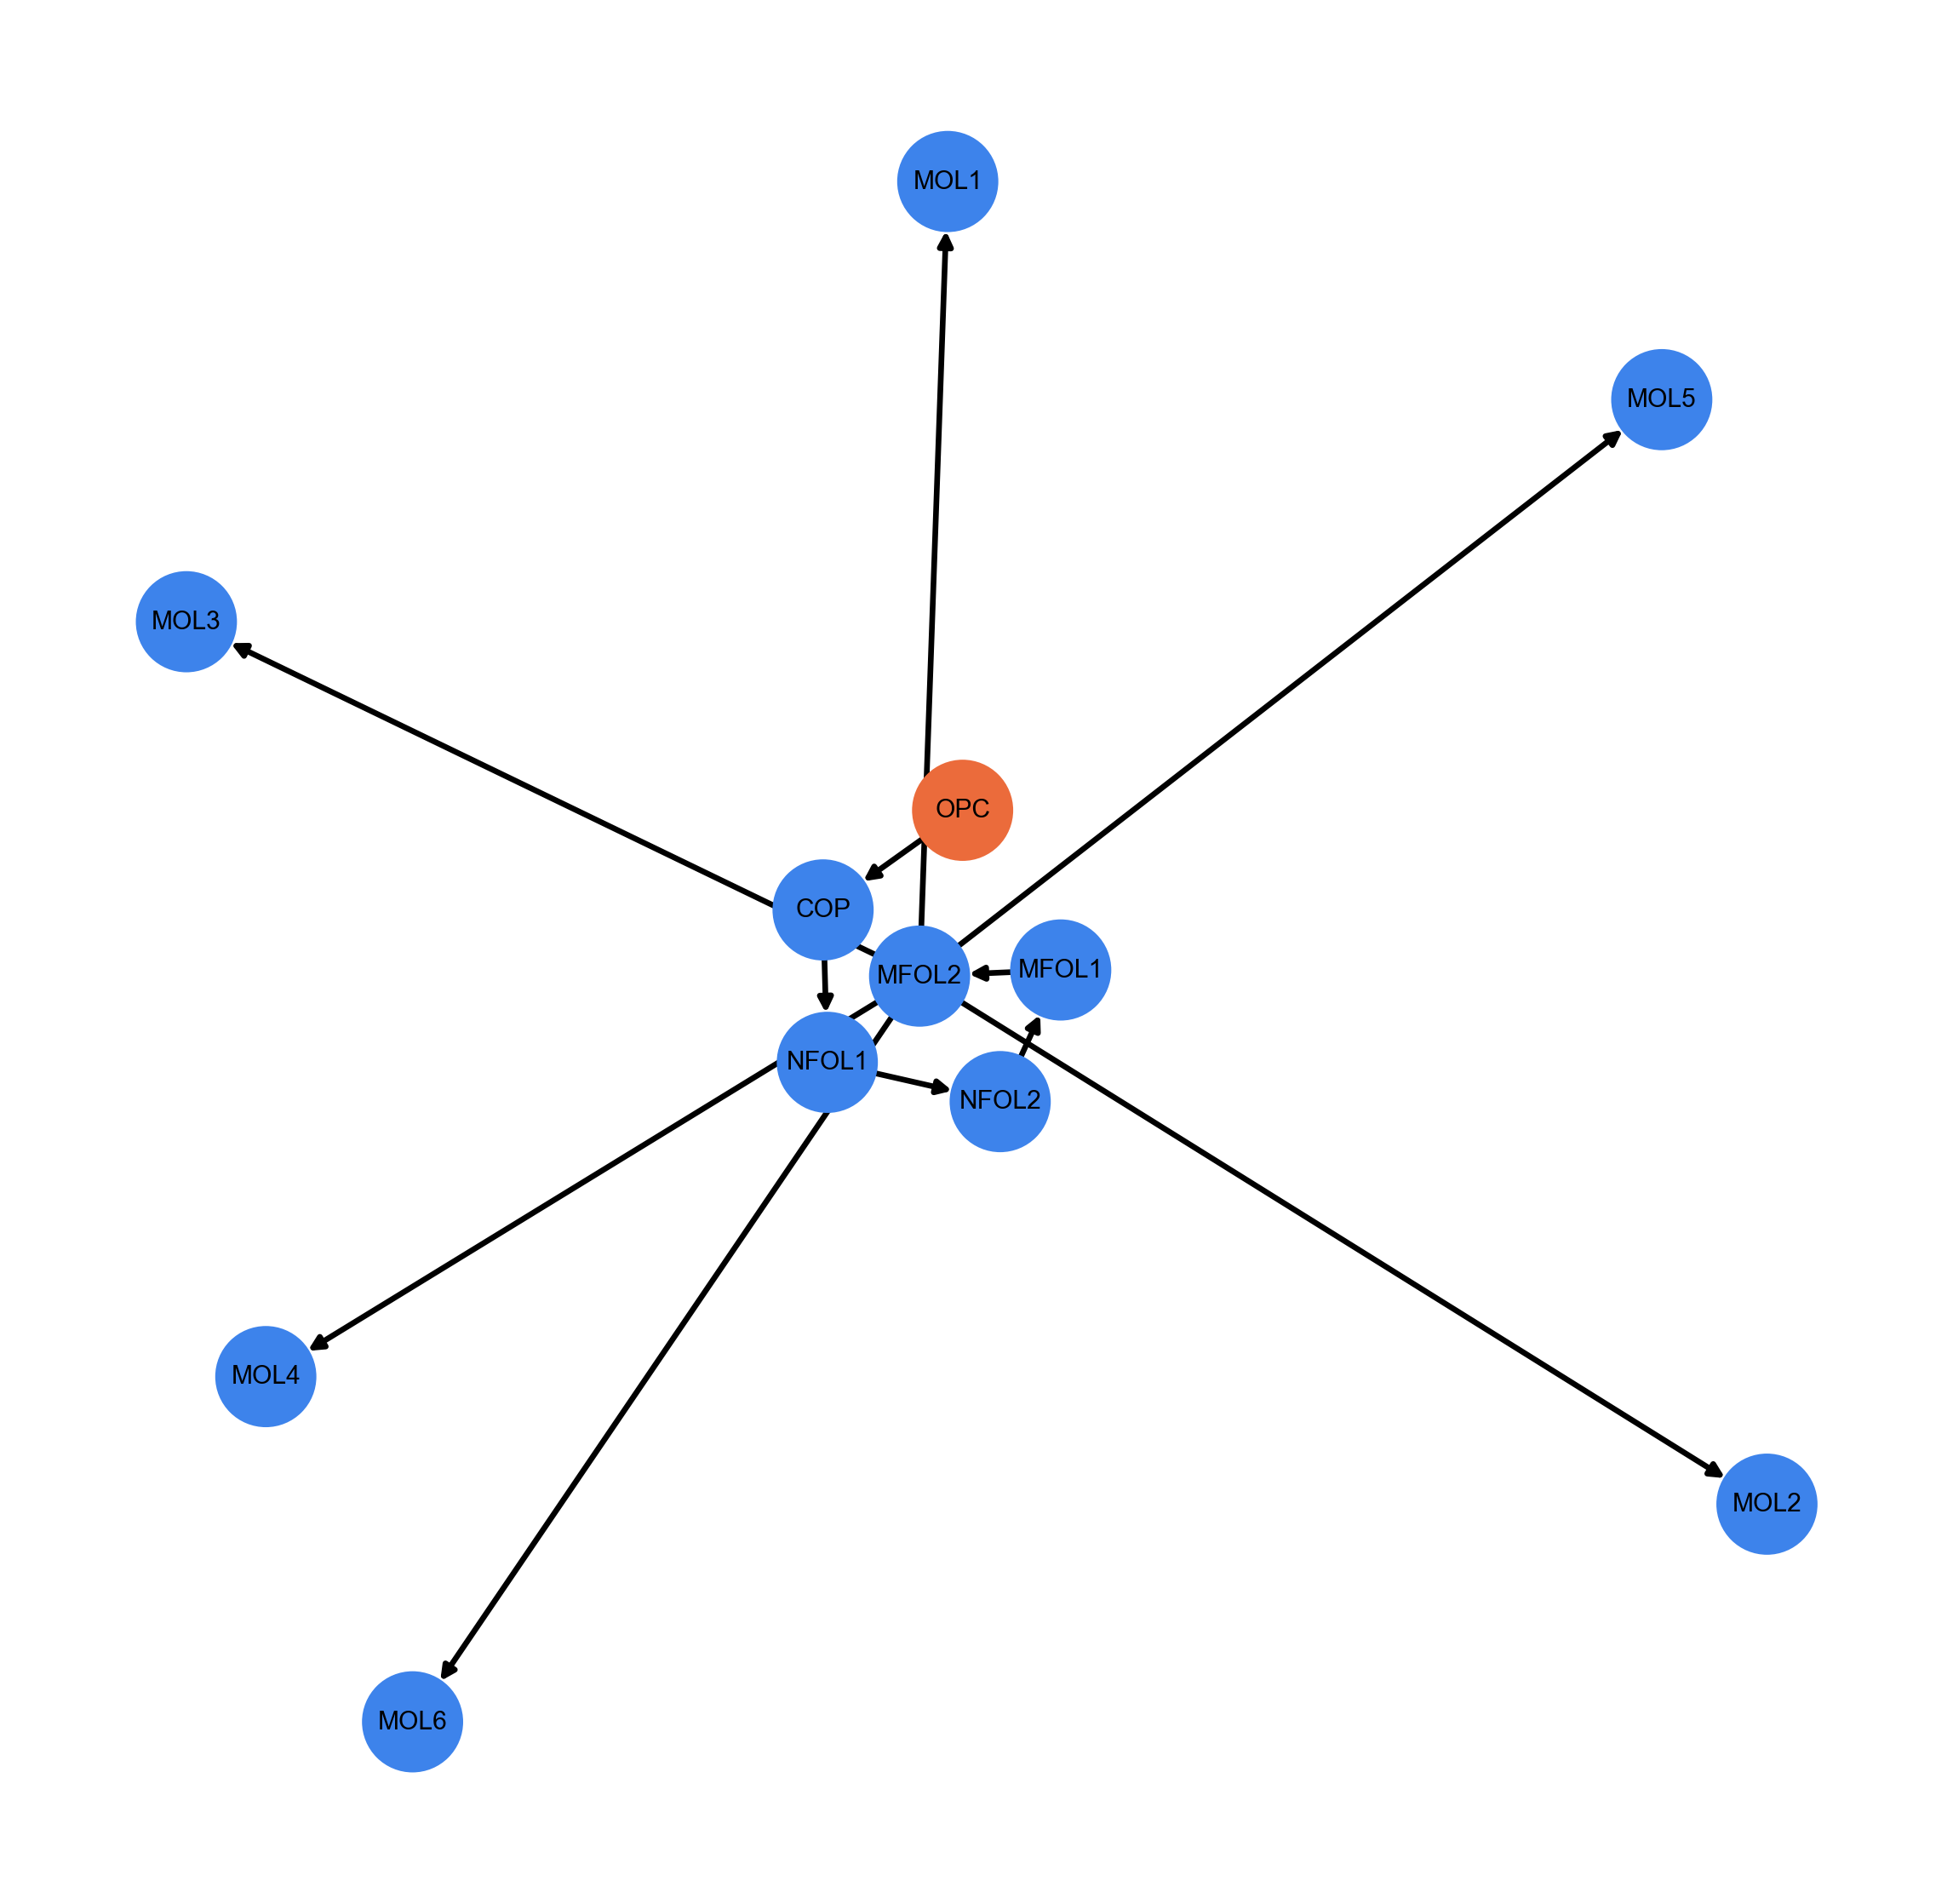

In [10]:
from utils.plot import plot_gt_milestone_network

plot_gt_milestone_network(adata, start_node_color='#EB6B3B', node_color='#3D83EB', node_size=1200)

In [11]:
# Extract the index of the start cell(s) from adata.obs_names
start_ids = [np.where(adata.obs_names == start_id)[0][0] for start_id in np.atleast_1d(adata.uns['start_id'])]
start_ids

[221]

In [12]:
from utils.util import preprocess_recipe

# Preprocessing using Seurat default parameters
min_expr_level = 3
min_cells = None
use_hvg = False
n_top_genes = 1000
preprocessed_data = preprocess_recipe(
    adata,
    min_expr_level=min_expr_level,
    min_cells=min_cells,
    use_hvg=use_hvg,
    n_top_genes=n_top_genes,
    scale=True
)

Preprocessing....
	->Removed cells with expression level<3
	->Normalized data
	->Applying z-score normalization
Pre-processing complete. Updated data shape: (4930, 3534)
Runtime for preprocess_recipe(): 1.1605324745178223


In [13]:
from utils.util import run_pca

# Apply PCA on the raw data for initial denoising
print('Computing PCA...')
X_pca, _, n_comps = run_pca(preprocessed_data, use_hvg=False, n_components=10)
preprocessed_data.obsm['X_pca'] = X_pca
print(f'Components computed: {n_comps}')

Computing PCA...
Runtime for run_pca(): 0.7662532329559326
Components computed: 10


In [14]:
gt_clusters = pd.Series(index=preprocessed_data.obs_names)

In [15]:
for obs_name in preprocessed_data.obs_names:
    res = (preprocessed_data.uns['milestone_percentages']['cell_id'] == obs_name)
    milestones = preprocessed_data.uns['milestone_percentages'].loc[res, 'milestone_id']
    percentages = preprocessed_data.uns['milestone_percentages'].loc[res, 'percentage']
    cluster_id = milestones.loc[percentages.idxmax()]
    gt_clusters.loc[obs_name] = cluster_id

In [16]:
preprocessed_data.obs['gt_clusters'] = gt_clusters

# VIA

In [17]:
import pyVIA.core as via

In [18]:
resolution = 1.0

In [19]:
# v0 = via.VIA(preprocessed_data.obsm['X_pca'], preprocessed_data.obs['gt_clusters'], jac_std_global=0.15, dist_std_local=1, knn=30,
#              too_big_factor=0.3, root_user=start_ids, dataset='', random_seed=0, resolution_parameter=resolution, preserve_disconnected=True)  # *.4 root=1,
# v0.run_VIA()

In [20]:
v0 = via.VIA(
    preprocessed_data.obsm['X_pca'],
    preprocessed_data.obs['gt_clusters'],
    # jac_std_global=0.15,
    # dist_std_local=1,
    knn=30,
    too_big_factor=0.3,
    root_user=start_ids,
    dataset='',
    random_seed=0,
    resolution_parameter=resolution,
)
v0.run_VIA()

2025-04-15 01:30:36.234383	Running VIA over input data of 4930 (samples) x 10 (features)
2025-04-15 01:30:36.234487	Knngraph has 30 neighbors
2025-04-15 01:30:38.406594	Finished global pruning of 30-knn graph used for clustering at level of 0.15. Kept 49.4 % of edges. 
2025-04-15 01:30:38.435496	Number of connected components used for clustergraph  is 1
2025-04-15 01:30:38.704572	Commencing community detection
2025-04-15 01:30:39.083241	Finished community detection. Found 79 clusters.
2025-04-15 01:30:39.085366	Merging 53 very small clusters (<10)
2025-04-15 01:30:39.087715	Finished detecting communities. Found 26 communities
2025-04-15 01:30:39.088078	Making cluster graph. Global cluster graph pruning level: 0.15
2025-04-15 01:30:39.103383	Graph has 1 connected components before pruning
2025-04-15 01:30:39.105202	Graph has 1 connected components after pruning
2025-04-15 01:30:39.105315	Graph has 1 connected components after reconnecting
2025-04-15 01:30:39.106081	0.0% links trimmed fr

/home/satwik/dynooenv/lib/python3.12/site-packages/pyVIA/core.py:176: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  g.set_node_ids(node_ids=None,


  0%|          | 0/1300 [00:00<?, ?it/s]

memory for rw2 hittings times  2. Using rw2 based pt
2025-04-15 01:30:47.875033	Identifying terminal clusters corresponding to unique lineages...
2025-04-15 01:30:47.875066	Closeness:[2, 3, 6, 7, 10, 11, 12, 14, 15, 16, 17, 20, 21, 25]
2025-04-15 01:30:47.875078	Betweenness:[1, 2, 5, 6, 7, 10, 11, 14, 15, 18, 20, 21, 22, 23, 25]
2025-04-15 01:30:47.875087	Out Degree:[2, 6, 7, 11, 12, 14, 15, 16, 17, 19, 20, 21, 22, 23, 25]
2025-04-15 01:30:47.875231	Cluster 2 had 3 or more neighboring terminal states [6, 11, 17, 21, 22] and so we removed cluster 22
2025-04-15 01:30:47.875255	Cluster 6 had 3 or more neighboring terminal states [2, 17, 20] and so we removed cluster 6
2025-04-15 01:30:47.875269	Cluster 7 had 3 or more neighboring terminal states [14, 15, 23] and so we removed cluster 14
2025-04-15 01:30:47.875284	Cluster 11 had 3 or more neighboring terminal states [2, 17, 21] and so we removed cluster 21
2025-04-15 01:30:47.875312	Cluster 17 had 3 or more neighboring terminal states [2, 

/home/satwik/dynooenv/lib/python3.12/site-packages/pyVIA/core.py:176: UserWarning: WARNING: Implicitly set node IDs to the canonical node ordering due to missing IDs field in the raw CSR npz file. This warning message can be suppressed by setting implicit_ids to True in the read_npz function call, or by setting the --implicit_ids flag in the CLI
  g.set_node_ids(node_ids=None,


  0%|          | 0/1000 [00:00<?, ?it/s]

2025-04-15 01:30:52.356970	Cluster or terminal cell fate 2 is reached 851.0 times
2025-04-15 01:30:52.392336	Cluster or terminal cell fate 11 is reached 851.0 times
2025-04-15 01:30:52.430945	Cluster or terminal cell fate 15 is reached 377.0 times
2025-04-15 01:30:52.468506	Cluster or terminal cell fate 17 is reached 886.0 times
2025-04-15 01:30:52.515876	Cluster or terminal cell fate 20 is reached 76.0 times
2025-04-15 01:30:52.549936	Cluster or terminal cell fate 23 is reached 717.0 times
2025-04-15 01:30:52.555200	There are (6) terminal clusters corresponding to unique lineages {2: 'MOL5', 11: 'MOL2', 15: 'MOL5', 17: 'MOL4', 20: 'MOL5', 23: 'MOL5'}
2025-04-15 01:30:52.555249	Begin projection of pseudotime and lineage likelihood
2025-04-15 01:30:53.278299	Cluster graph layout based on forward biasing
2025-04-15 01:30:53.282070	Starting make edgebundle viagraph...
2025-04-15 01:30:53.282126	Make via clustergraph edgebundle
2025-04-15 01:30:53.603807	Hammer dims: Nodes shape: (26, 2) E

In [21]:
import networkx as nx

via_graph = nx.Graph()

for pair in v0.edgelist:
    n1, n2 = pair
    via_graph.add_edge(n1, n2)

In [22]:
from metrics.ipsen import IpsenMikhailov
from models.ti.graph import compute_gt_milestone_network


gt_graph = net1 = compute_gt_milestone_network(preprocessed_data, mode="undirected")
im = IpsenMikhailov()
dist = im(via_graph, gt_graph)

print(dist)

Runtime for compute_gt_milestone_network(): 0.0018963813781738281
0.8124181437682342


In [23]:
from metrics.ordering import compute_ranking_correlation


via_pt = v0.single_cell_pt_markov
gt_pseudotime = preprocessed_data.uns["timecourse"].reindex(preprocessed_data.obs_names)

res = compute_ranking_correlation(gt_pseudotime, via_pt)
print(res)

{'kendall': SignificanceResult(statistic=0.6905056634548805, pvalue=0.0), 'weighted_kendall': SignificanceResult(statistic=0.6651361845401651, pvalue=nan), 'spearman': SignificanceResult(statistic=0.8077699322026229, pvalue=0.0)}


In [24]:
print(via_pt)

[0.0, 0.0, 0.0, 0.0, 0.0, 0.5507376311453543, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05413791574126208, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.05413791574126208, 0.0, 0.0, 0.0, 0.05413791574126208, 0.0, 0.0, 0.0, 0.9501227609528189, 0.9205823452568563, 0.0, 0.9205823452568563, 0.4248263244182588, 0.9205823452568563, 0.2347378022483132, 0.5309494079734716, 0.5507376311453543, 0.6070816898758823, 0.0, 0.9501227609528189, 0.0, 0.4112638067181305, 0.5507376311453543, 0.0, 0.5507376311453543, 0.0, 0.11476194283997883, 0.6070816898758823, 0.5507376311453543, 0.0, 0.0, 0.0, 0.0, 0.0, 0.11476194283997883, 0.05413791574126208, 0.0, 0.0, 0.05413791574126208, 0.0, 0.05413791574126208, 0.05413791574126208, 0.0, 0.0, 0.0, 0.05413791574126208, 0.11476194283997883, 0.0, 0.0, 0.05413791574126208, 0.0, 0.0, 0.05413791574126208, 0.0, 0.05413791574126208, 0.0, 0.0, 0.0, 0.0, 0.0, 

# Via metrics

In [25]:
%%R
dataset <- readRDS("oligodendrocyte-differentiation-subclusters_marques(1).rds")

In [26]:
%%R
library(dyndimred)
pca_dimred <- dimred_pca(
  dataset$expression
)

In [27]:
%%R
v_dataset <- readRDS("oligodendrocyte-differentiation-subclusters_marques(1).rds")

In [28]:
cell_ids = preprocessed_data.obs_names.to_list()
v_pseudotime = pd.Series(v0.single_cell_pt_markov, index=cell_ids)
v_milestone_ids = [i for i in range(len(set(v0.labels)))]
v_hard_clusters = v0.labels

In [29]:
fromlist = []
tolist = []
for t in v0.edgelist:
    if(t[0] > t[1]):
        continue
    fromlist.append(str(t[0]))
    tolist.append(str(t[1]))
v_edges_df = pd.DataFrame({'from': fromlist, 'to': tolist, 'length': 1, 'directed': False})
v_edges_df

from  to  length  directed
0     0   1       1     False
1     0   2       1     False
2     0   5       1     False
3     0   6       1     False
4     0   9       1     False
..  ...  ..     ...       ...
71   16  25       1     False
72   17  21       1     False
73   18  23       1     False
74   19  23       1     False
75   21  22       1     False

[76 rows x 4 columns]

In [30]:
for i in range(len(v_milestone_ids)):
    v_milestone_ids[i] = str(v_milestone_ids[i])

In [31]:
labels = v0.labels.copy()
for i in range(len(labels)):
    labels[i] = str(labels[i])
v_milestone_percentages = pd.DataFrame({'cell_id': cell_ids, 'milestone_id': labels, 'percentage': [1 for i in range(len(labels))]})

In [32]:
%%R -i cell_ids -i v_pseudotime -i v_milestone_ids -i v_milestone_percentages -i v_edges_df
v_traj <- add_trajectory(
  v_dataset,
  cell_ids = cell_ids,
  pseudotime = v_pseudotime,
  milestone_ids = as.vector(v_milestone_ids),
  milestone_percentages = v_milestone_percentages,
  milestone_network = v_edges_df
)

In [33]:
%%R
table(dataset$progressions$percentage)


   0    1 
 272 4658 


In [38]:
%%R
groups <- dataset$grouping

In [39]:
%%R
library(RColorBrewer)
palette <- brewer.pal(n = length(unique(dataset$grouping)), name = "Set3")

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


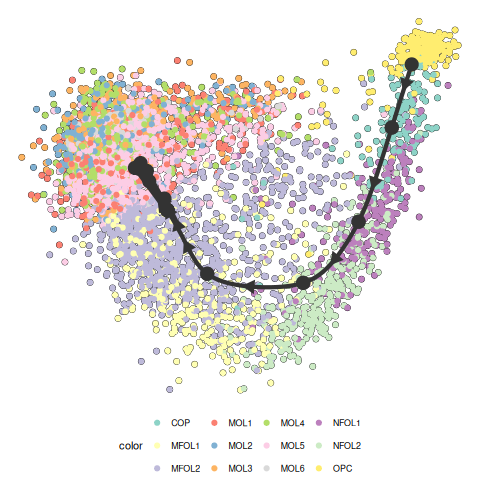

In [40]:
%%R

plot_dimred(dataset, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


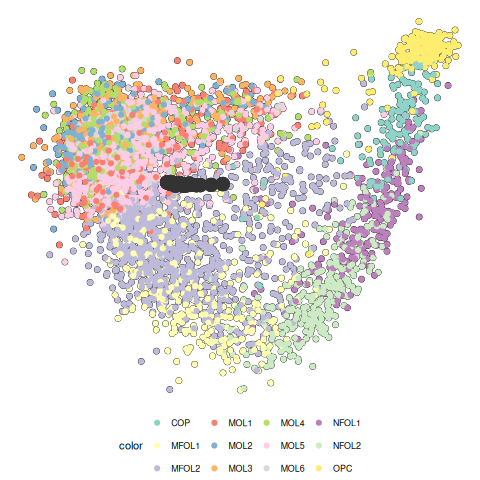

In [41]:
%%R

plot_dimred(v_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

In [35]:
%%R
library(dyneval)

In [179]:
%%R
via_metrics <- calculate_metrics(
  dataset = v_dataset,
  model = v_traj,
  metrics = dyneval::metrics$metric_id,
  expression_source = v_dataset$expression
)

In [37]:
%%R
cat("HIM =", via_metrics$him, "\n")
cat("F1_branches =", via_metrics$F1_branches, "\n")
cat("correlation =", via_metrics$correlation, "\n")
cat("featureimp_wcor =", via_metrics$featureimp_wcor, "\n")
v_selected_metrics <- c(
  him = as.numeric(via_metrics$him),
  F1_branches = via_metrics$F1_branches,
  correlation = via_metrics$correlation,
  featureimp_wcor = via_metrics$featureimp_wcor
)
v_overall_score <- exp(mean(log(v_selected_metrics)))
cat("overall_score =", v_overall_score, "\n")

HIM = 0.4631021 
F1_branches = 0.07034829 
correlation = 0.6224461 
featureimp_wcor = 0.8130893 
overall_score = 0.3583378 


# margaret

In [42]:
import warnings
from train_metric import train_metric_learner

with warnings.catch_warnings():
    # Filter out user warnings from PyTorch about saving scheduler state
    warnings.simplefilter("ignore")
    train_metric_learner(preprocessed_data, n_episodes=10, n_metric_epochs=10, obsm_data_key='X_pca', code_size=10,
        backend='leiden', device='cpu', save_path='metric',
        # cluster_kwargs={'random_state': 0, 'n_clusters': 30}, nn_kwargs={'random_state': 0, 'n_neighbors': 10},
        cluster_kwargs={'random_state': 0, 'resolution': 1.0}, nn_kwargs={'random_state': 0, 'n_neighbors': 30},
        trainer_kwargs={
            'optimizer': 'SGD',
            'lr': 0.01,
            'batch_size': 256,
            'train_loader_kwargs': {'num_workers': 2, 'pin_memory': True, 'drop_last': True}
        },
        loss_kwargs={
            'margin': 1.0,
            'p': 2
        }
    )

Generating initial clusters
Runtime for determine_cell_clusters(): 5.329294681549072
Training for episode: 1


100%|██████████| 4930/4930 [00:00<00:00, 10289.06it/s]


Re-generating clusters for episode: 1
Runtime for determine_cell_clusters(): 2.1268861293792725
Time Elapsed for epoch: 20.083834886550903s
Training for episode: 2


100%|██████████| 4930/4930 [00:00<00:00, 10112.62it/s]


Re-generating clusters for episode: 2
Runtime for determine_cell_clusters(): 1.8681232929229736
Time Elapsed for epoch: 22.783984184265137s
Training for episode: 3


100%|██████████| 4930/4930 [00:00<00:00, 12061.51it/s]


Re-generating clusters for episode: 3
Runtime for determine_cell_clusters(): 2.182938575744629
Time Elapsed for epoch: 21.868226289749146s
Training for episode: 4


100%|██████████| 4930/4930 [00:00<00:00, 11809.89it/s]


Re-generating clusters for episode: 4
Runtime for determine_cell_clusters(): 2.1350018978118896
Time Elapsed for epoch: 22.22155737876892s
Training for episode: 5


100%|██████████| 4930/4930 [00:00<00:00, 11828.76it/s]


Re-generating clusters for episode: 5
Runtime for determine_cell_clusters(): 1.6419413089752197
Time Elapsed for epoch: 20.54162907600403s
Training for episode: 6


100%|██████████| 4930/4930 [00:00<00:00, 9532.62it/s] 


Re-generating clusters for episode: 6
Runtime for determine_cell_clusters(): 1.8950645923614502
Time Elapsed for epoch: 21.1510169506073s
Training for episode: 7


100%|██████████| 4930/4930 [00:00<00:00, 9838.86it/s] 


Re-generating clusters for episode: 7
Runtime for determine_cell_clusters(): 1.918363332748413
Time Elapsed for epoch: 20.34829044342041s
Training for episode: 8


100%|██████████| 4930/4930 [00:00<00:00, 10864.53it/s]


Re-generating clusters for episode: 8
Runtime for determine_cell_clusters(): 2.1680216789245605
Time Elapsed for epoch: 20.667280673980713s
Training for episode: 9


100%|██████████| 4930/4930 [00:00<00:00, 10328.02it/s]


Re-generating clusters for episode: 9
Runtime for determine_cell_clusters(): 1.829275369644165
Time Elapsed for epoch: 20.246995210647583s
Training for episode: 10


100%|██████████| 4930/4930 [00:00<00:00, 10557.22it/s]


Re-generating clusters for episode: 10
Runtime for determine_cell_clusters(): 2.0788702964782715
Time Elapsed for epoch: 21.066030502319336s
Runtime for train_metric_learner(): 217.83341121673584


In [43]:
from utils.plot import generate_plot_embeddings, plot_gene_expression, plot_embeddings, plot_clusters
import matplotlib.pyplot as plt

In [44]:
X_embedded = generate_plot_embeddings(preprocessed_data.obsm['metric_embedding'], method='umap', random_state=random_seed)
preprocessed_data.obsm['X_met_embedding'] = X_embedded

/home/satwik/dynooenv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Runtime for generate_plot_embeddings(): 15.821803569793701


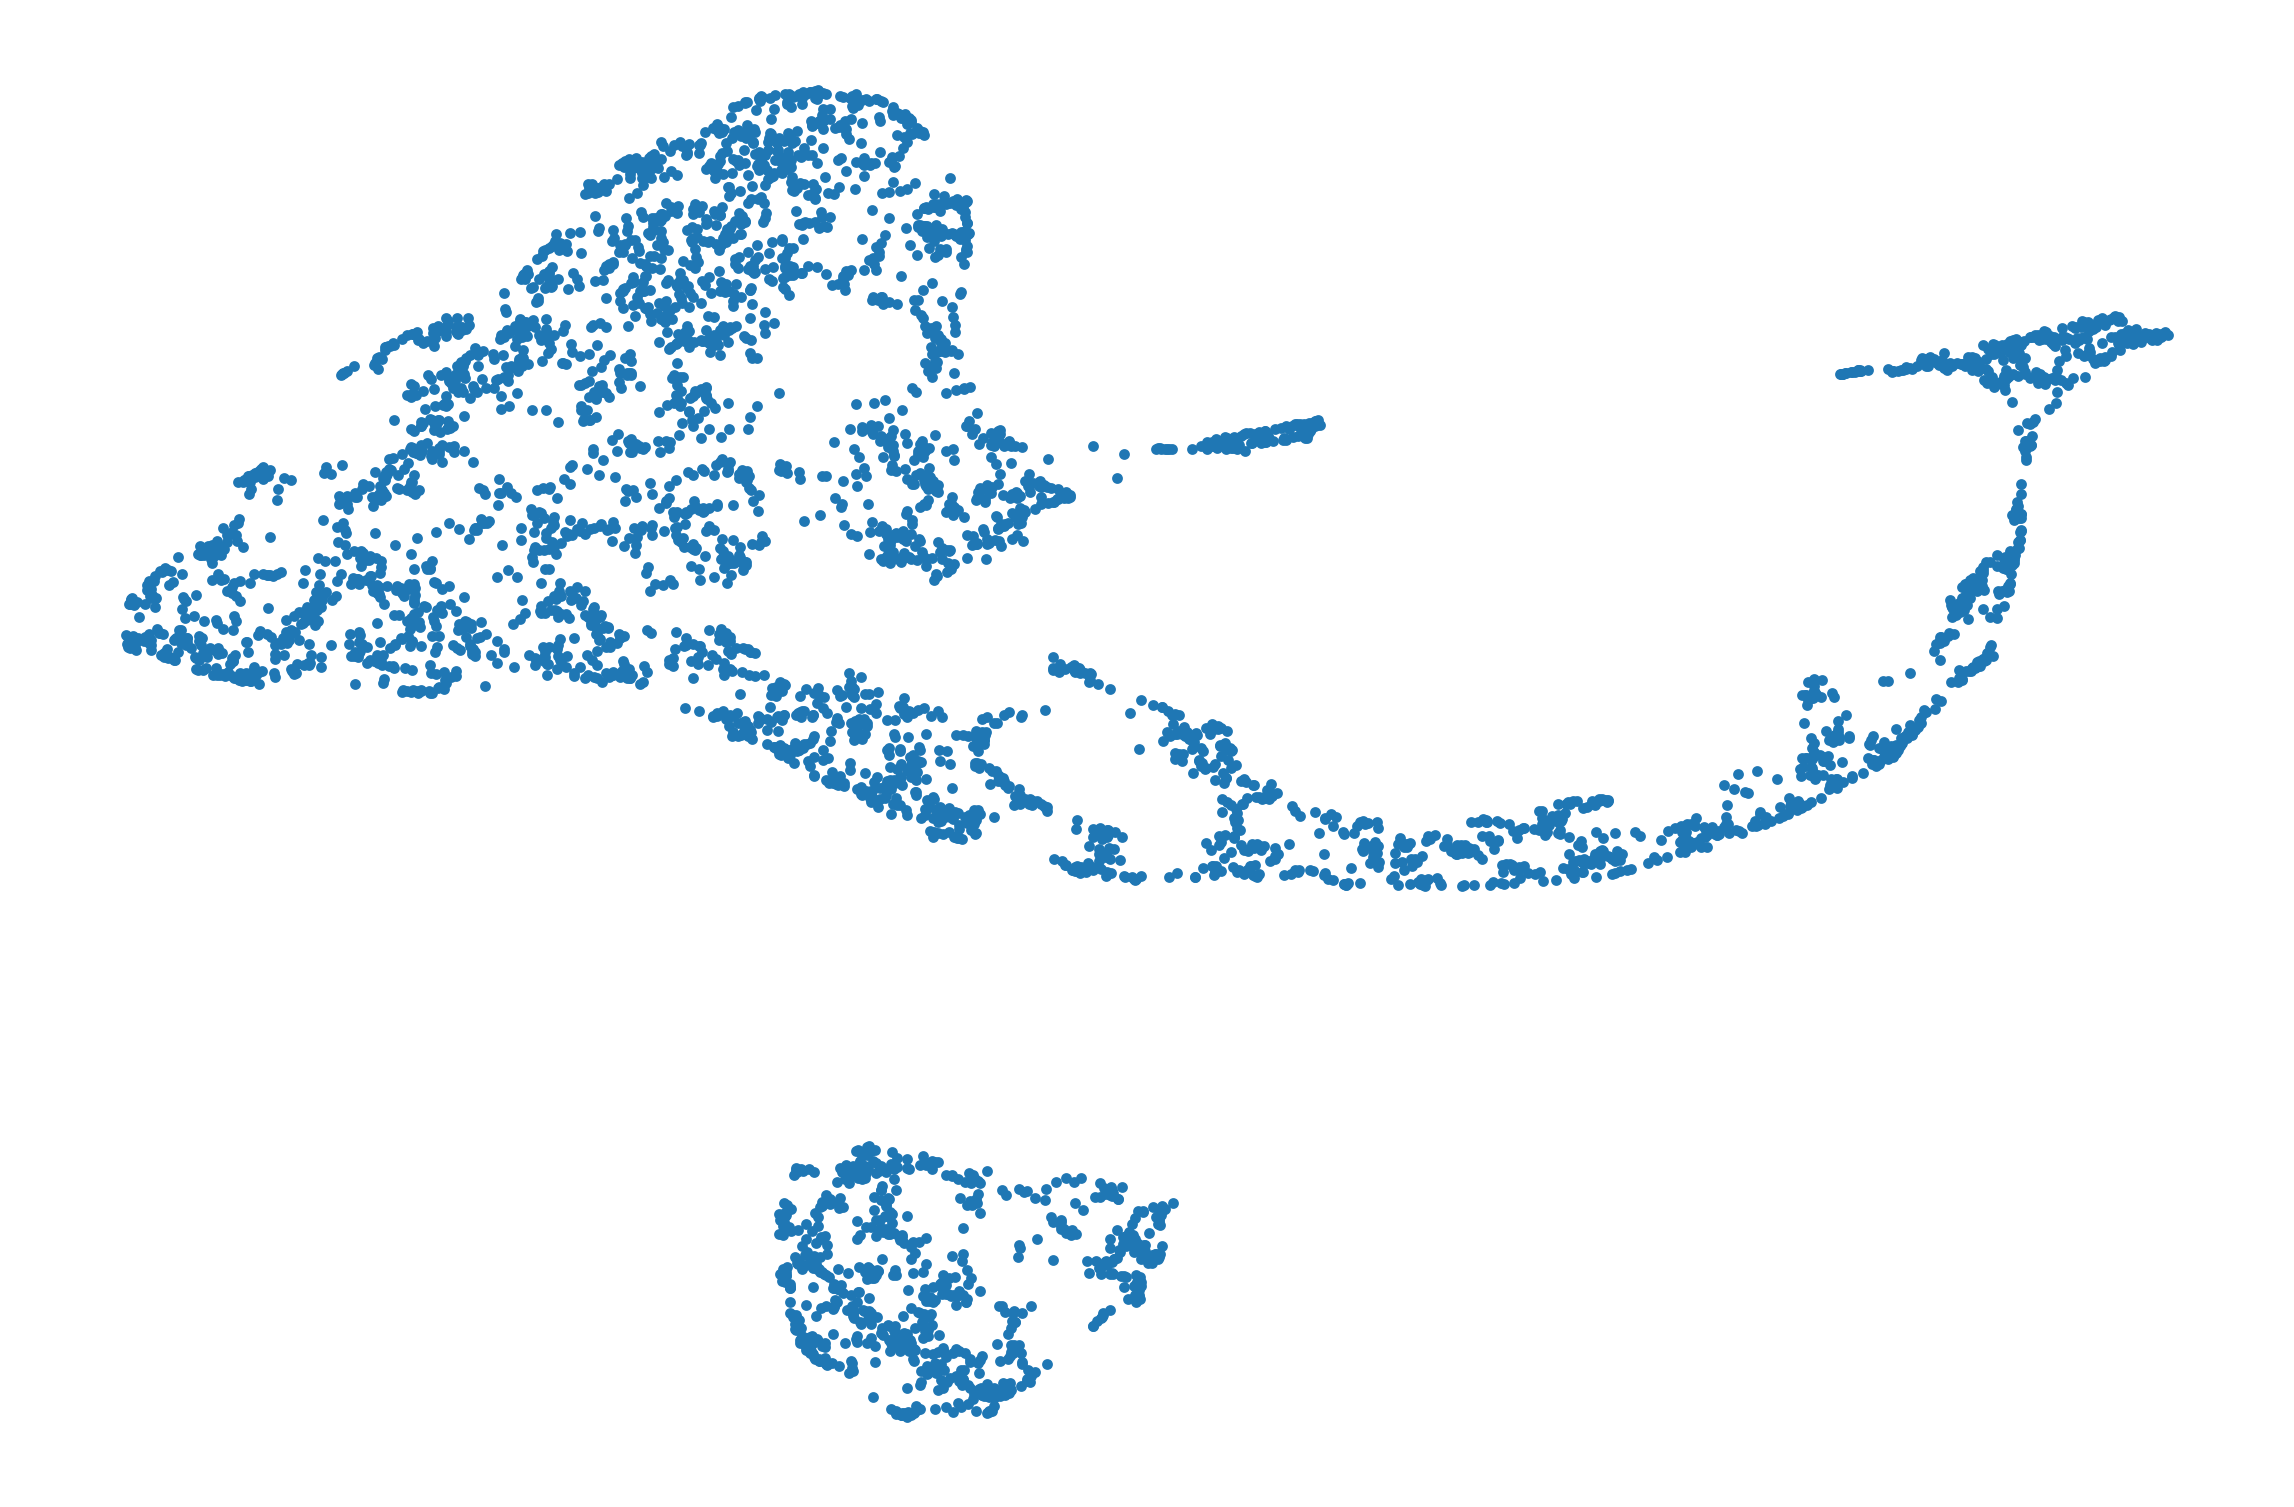

In [45]:
plot_embeddings(X_embedded, s=5)

In [46]:
import numpy as np

from sklearn.neighbors import NearestNeighbors

from models.ti.connectivity import compute_directed_cluster_connectivity, compute_undirected_cluster_connectivity
from models.ti.graph import compute_trajectory_graph, compute_connectivity_graph
from utils.plot import plot_connectivity_graph, plot_trajectory_graph, plot_connectivity_graph_with_gene_expressions
from utils.util import get_start_cell_cluster_id

In [47]:
communities = preprocessed_data.obs['metric_clusters'].to_numpy().astype(int)

In [48]:
X = preprocessed_data.obsm['metric_embedding']

n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
adj_dist = nbrs.kneighbors_graph(X, mode="distance")
adj_conn = nbrs.kneighbors_graph(X)

In [49]:
start_cell_ids = preprocessed_data.uns['start_id']
start_cell_ids = list((start_cell_ids,))
start_cell_ids

['C1-1771051-158-E04']

In [50]:
start_cluster_ids = get_start_cell_cluster_id(preprocessed_data, start_cell_ids, communities)
start_cluster_ids

{8}

In [51]:
un_connectivity, un_z_score = compute_undirected_cluster_connectivity(communities, adj_conn, z_threshold=0.6)
pd.DataFrame(un_z_score)

Runtime for compute_undirected_cluster_connectivity(): 0.36725687980651855


0         1         2         3         4         5         6   \
0   0.000000 -1.088287 -1.086268 -1.086983 -1.086173 -1.084773 -1.082834   
1  -1.088287  0.000000 -1.080286  0.648317 -1.079819 -1.078125 -1.074213   
2  -1.086268 -1.080286  0.000000  2.670438  2.317359  6.983511 -1.067792   
3  -1.086983  0.648317  2.670438  0.000000  3.332321 -1.071908 -1.066801   
4  -1.086173 -1.079819  2.317359  3.332321  0.000000  0.912271 -1.066822   
5  -1.084773 -1.078125  6.983511 -1.071908  0.912271  0.000000 -1.067463   
6  -1.082834 -1.074213 -1.067792 -1.066801 -1.066822 -1.067463  0.000000   
7  -1.081850 -0.204545 -0.354551  1.046245 -0.516589 -1.068651 -1.063583   
8  -1.074389 -1.067159 -1.064287 -1.063759 -1.063869 -1.064361 -1.062756   
9  -1.081039 -1.070161 -1.062824  0.346591  1.051690 -1.063222 -1.059284   
10 -1.082828 -1.072475 -1.064222 -0.785633  3.174494 -1.064441 -1.059906   
11  7.987794 -0.593291 -0.567790 -0.417551 -1.059066 -1.056684 -0.734441   
12 -1.084593  3.913142 -1.063505  2.688046 -1.045186 -1.063939 -1.058197   
13 -1.078606 -1.063761 -1.054448 -1.050965 -1.052660 -1.056257  8.169650   
14 -1.079527 -1.064583  3.417848 -1.014542  0.758406  5.901883 -1.051764   
15 -1.069467 -1.052115 -1.044847 -1.041740 -1.043424 -1.047152 -1.044232   
16 -1.078294  6.805928 -1.052512 -1.048486 -1.050538 -1.054718  7.458762   
17  5.227385 -1.062585 -1.052560 -1.048510 -1.050574 -1.054771  2.693065   
18 -1.082058  4.676919 -1.057256 -1.005730 -1.055042 -1.058947  4.530419   
19 -1.067195 -1.047365 -1.039269 -1.035424 -1.037613 -1.042297 -1.039289   

          7         8         9         10        11        12         13  \
0  -1.081850 -1.074389 -1.081039 -1.082828  7.987794 -1.084593  -1.078606   
1  -0.204545 -1.067159 -1.070161 -1.072475 -0.593291  3.913142  -1.063761   
2  -0.354551 -1.064287 -1.062824 -1.064222 -0.567790 -1.063505  -1.054448   
3   1.046245 -1.063759  0.346591 -0.785633 -0.417551  2.688046  -1.050965   
4  -0.516589 -1.063869  1.051690  3.174494 -1.059066 -1.045186  -1.052660   
5  -1.068651 -1.064361 -1.063222 -1.064441 -1.056684 -1.063939  -1.056257   
6  -1.063583 -1.062756 -1.059284 -1.059906 -0.734441 -1.058197   8.169650   
7   0.000000 -0.239941 -1.057679  0.900133  0.517190  1.505185  -0.218578   
8  -0.239941  0.000000 -1.060931 -1.061262 -1.052622 -1.060822  -0.719024   
9  -1.057679 -1.060931  0.000000  7.131976 -1.050590  6.208302  -1.046408   
10  0.900133 -1.061262  7.131976  0.000000 -1.049630  0.608117  -1.044861   
11  0.517190 -1.052622 -1.050590 -1.049630  0.000000  0.885182  -0.981338   
12  1.505185 -1.060822  6.208302  0.608117  0.885182  0.000000  -1.037817   
13 -0.218578 -0.719024 -1.046408 -1.044861 -0.981338 -1.037817   0.000000   
14  3.241231 -1.058252 -1.045727 -0.996789 -1.037604 -1.035456  -1.034614   
15 -1.031264  7.362441 -1.040269 -1.038592 -1.034789 -1.033415  12.481336   
16 -1.044546 -1.057570 -1.044410 -1.042418 -1.036327 -1.034070  -1.033684   
17 -1.044537 -0.953005 -1.044402 -1.042395  2.953220 -1.033956   0.175535   
18  2.877637 -1.059196 -1.046611 -1.044602 -0.172322 -1.033976   1.020829   
19  4.451549  1.273183 -1.035033  3.363817 -1.028281 -1.026101  -1.027389   

          14         15        16        17        18        19  
0  -1.079527  -1.069467 -1.078294  5.227385 -1.082058 -1.067195  
1  -1.064583  -1.052115  6.805928 -1.062585  4.676919 -1.047365  
2   3.417848  -1.044847 -1.052512 -1.052560 -1.057256 -1.039269  
3  -1.014542  -1.041740 -1.048486 -1.048510 -1.005730 -1.035424  
4   0.758406  -1.043424 -1.050538 -1.050574 -1.055042 -1.037613  
5   5.901883  -1.047152 -1.054718 -1.054771 -1.058947 -1.042297  
6  -1.051764  -1.044232  7.458762  2.693065  4.530419 -1.039289  
7   3.241231  -1.031264 -1.044546 -1.044537  2.877637  4.451549  
8  -1.058252   7.362441 -1.057570 -0.953005 -1.059196  1.273183  
9  -1.045727  -1.040269 -1.044410 -1.044402 -1.046611 -1.035033  
10 -0.996789  -1.038592 -1.042418 -1.042395 -1.044602  3.363817  
11 

Runtime for compute_connectivity_graph(): 0.0072154998779296875


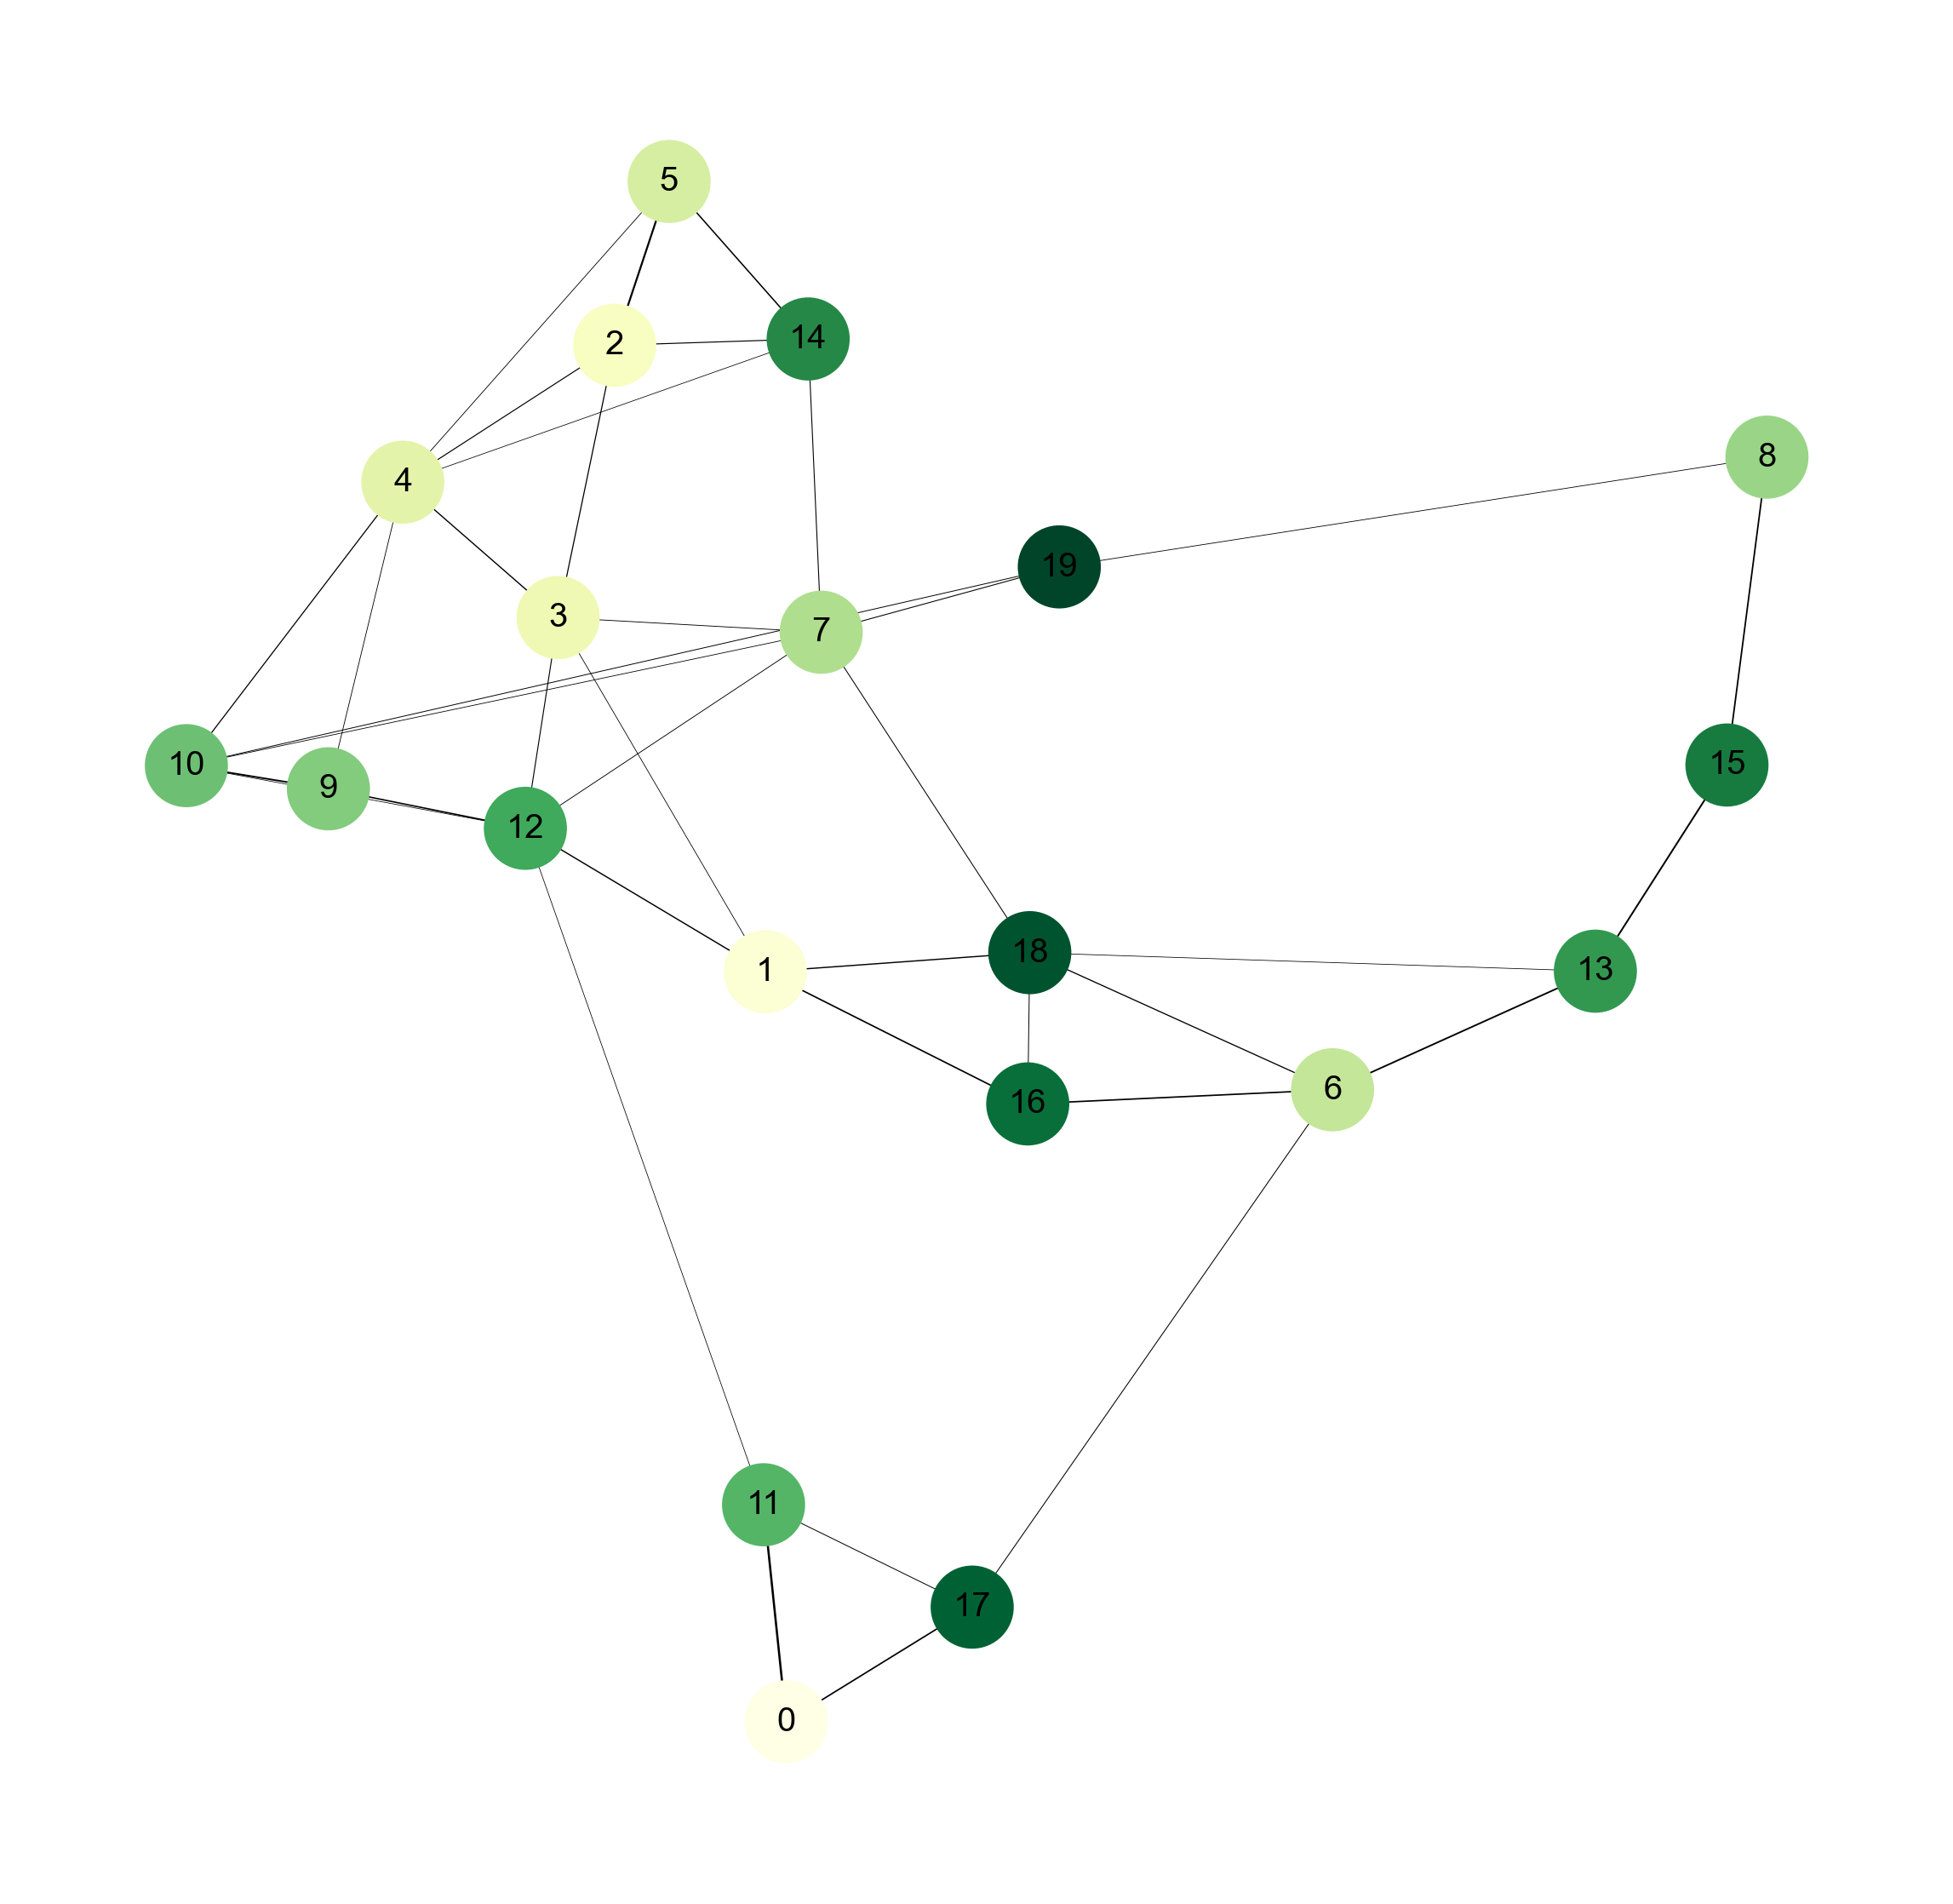

In [52]:
plot_connectivity_graph(preprocessed_data.obsm['X_met_embedding'], communities, un_connectivity, mode='undirected', offset=0.2)

In [53]:
connectivity, z_score = compute_directed_cluster_connectivity(communities, adj_conn, threshold=0.8)

Runtime for compute_directed_cluster_connectivity(): 0.09971070289611816


In [54]:
import networkx as nx

from sklearn.neighbors import NearestNeighbors

from models.ti.pseudotime import compute_pseudotime
from models.ti.pseudotime_v2 import compute_pseudotime
from models.ti.graph import compute_trajectory_graph_v2
from utils.plot import plot_trajectory_graph_v2
from utils.plot import plot_pseudotime

In [55]:
# v2 pseudotime
G_undirected, node_positions = compute_connectivity_graph(preprocessed_data.obsm['X_met_embedding'], preprocessed_data.obs['metric_clusters'], un_connectivity)
adj_cluster = nx.to_pandas_adjacency(G_undirected)
pseudotime = compute_pseudotime(preprocessed_data, start_cell_ids, adj_dist, adj_cluster)

Runtime for compute_connectivity_graph(): 0.007620811462402344
Runtime for compute_pseudotime(): 2.6863653659820557


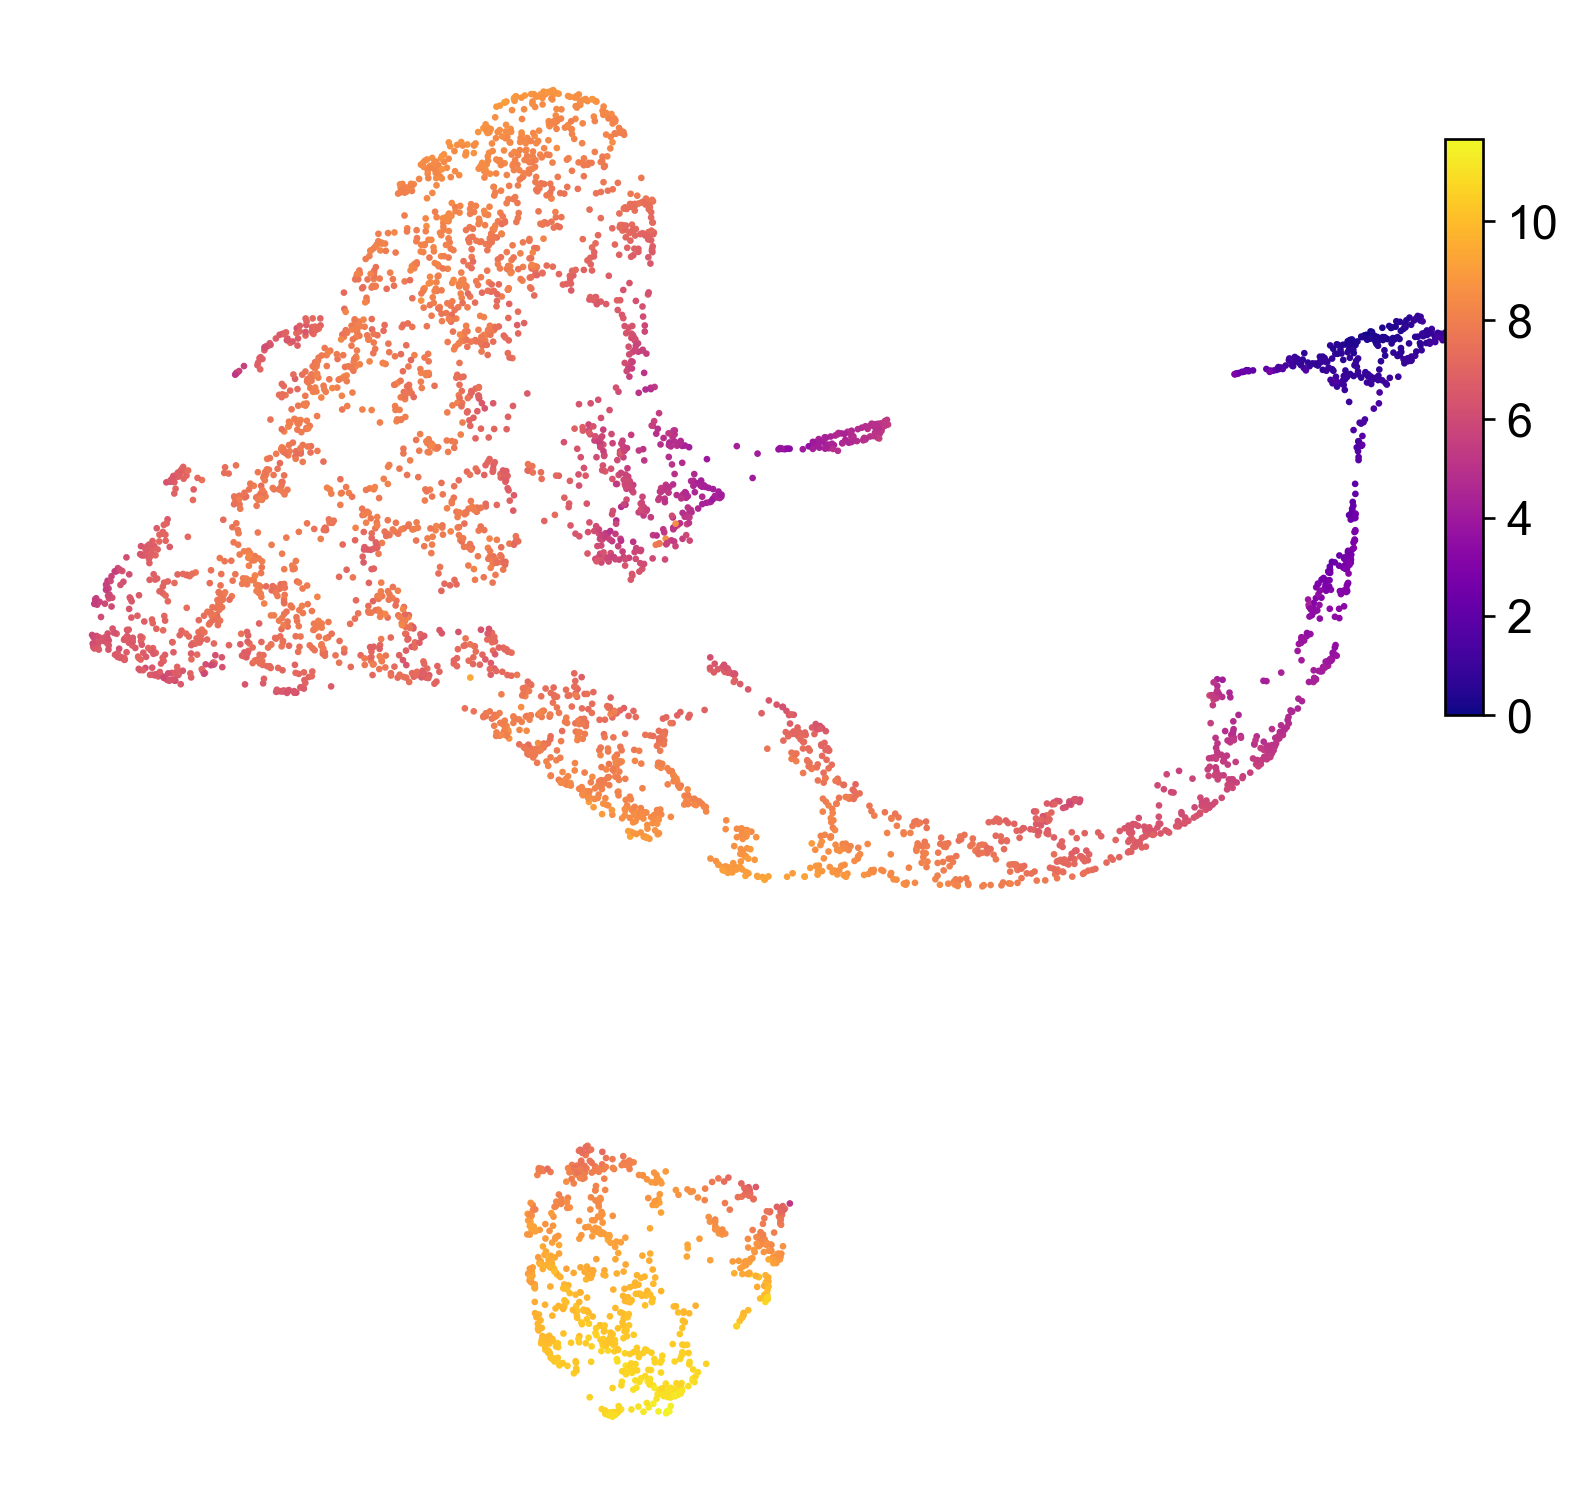

In [56]:
plot_pseudotime(
    preprocessed_data,
    embedding_key="X_met_embedding",
    pseudotime_key="metric_pseudotime_v2",
    s=1,
    cmap='plasma',
    figsize=(8, 8),
    cb_axes_pos=[0.92, 0.55, 0.02, 0.3]
)

In [57]:
# Compute directed graph v2
G_directed_v2 = compute_trajectory_graph_v2(pseudotime, adj_cluster, preprocessed_data.obs['metric_clusters'], connectivity)

Runtime for compute_trajectory_graph_v2(): 0.0403904914855957


In [58]:
color_map = {
    0: '#FA6B66',
    1: '#A6A78F',
    2: '#A6A78F',
    3: '#A6A78F',
    4: '#A6A78F',
    5: '#6EAAAF',
    6: '#6EAAAF',
    7: '#6EAAAF',
    8: '#6EAAAF',
    9: '#6EAAAF',
    10: '#A6A78F'
}
color_map = {f'{idx}': '#A6A78F' for idx in range(22)}
color_map['16'] = '#FA6B66'
color_map['1'] = '#FA6B66'
color_map['0'] = '#FA6B66'

color_map['18'] = '#6EAAAF'
color_map['11'] = '#6EAAAF'
color_map['17'] = '#6EAAAF'

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


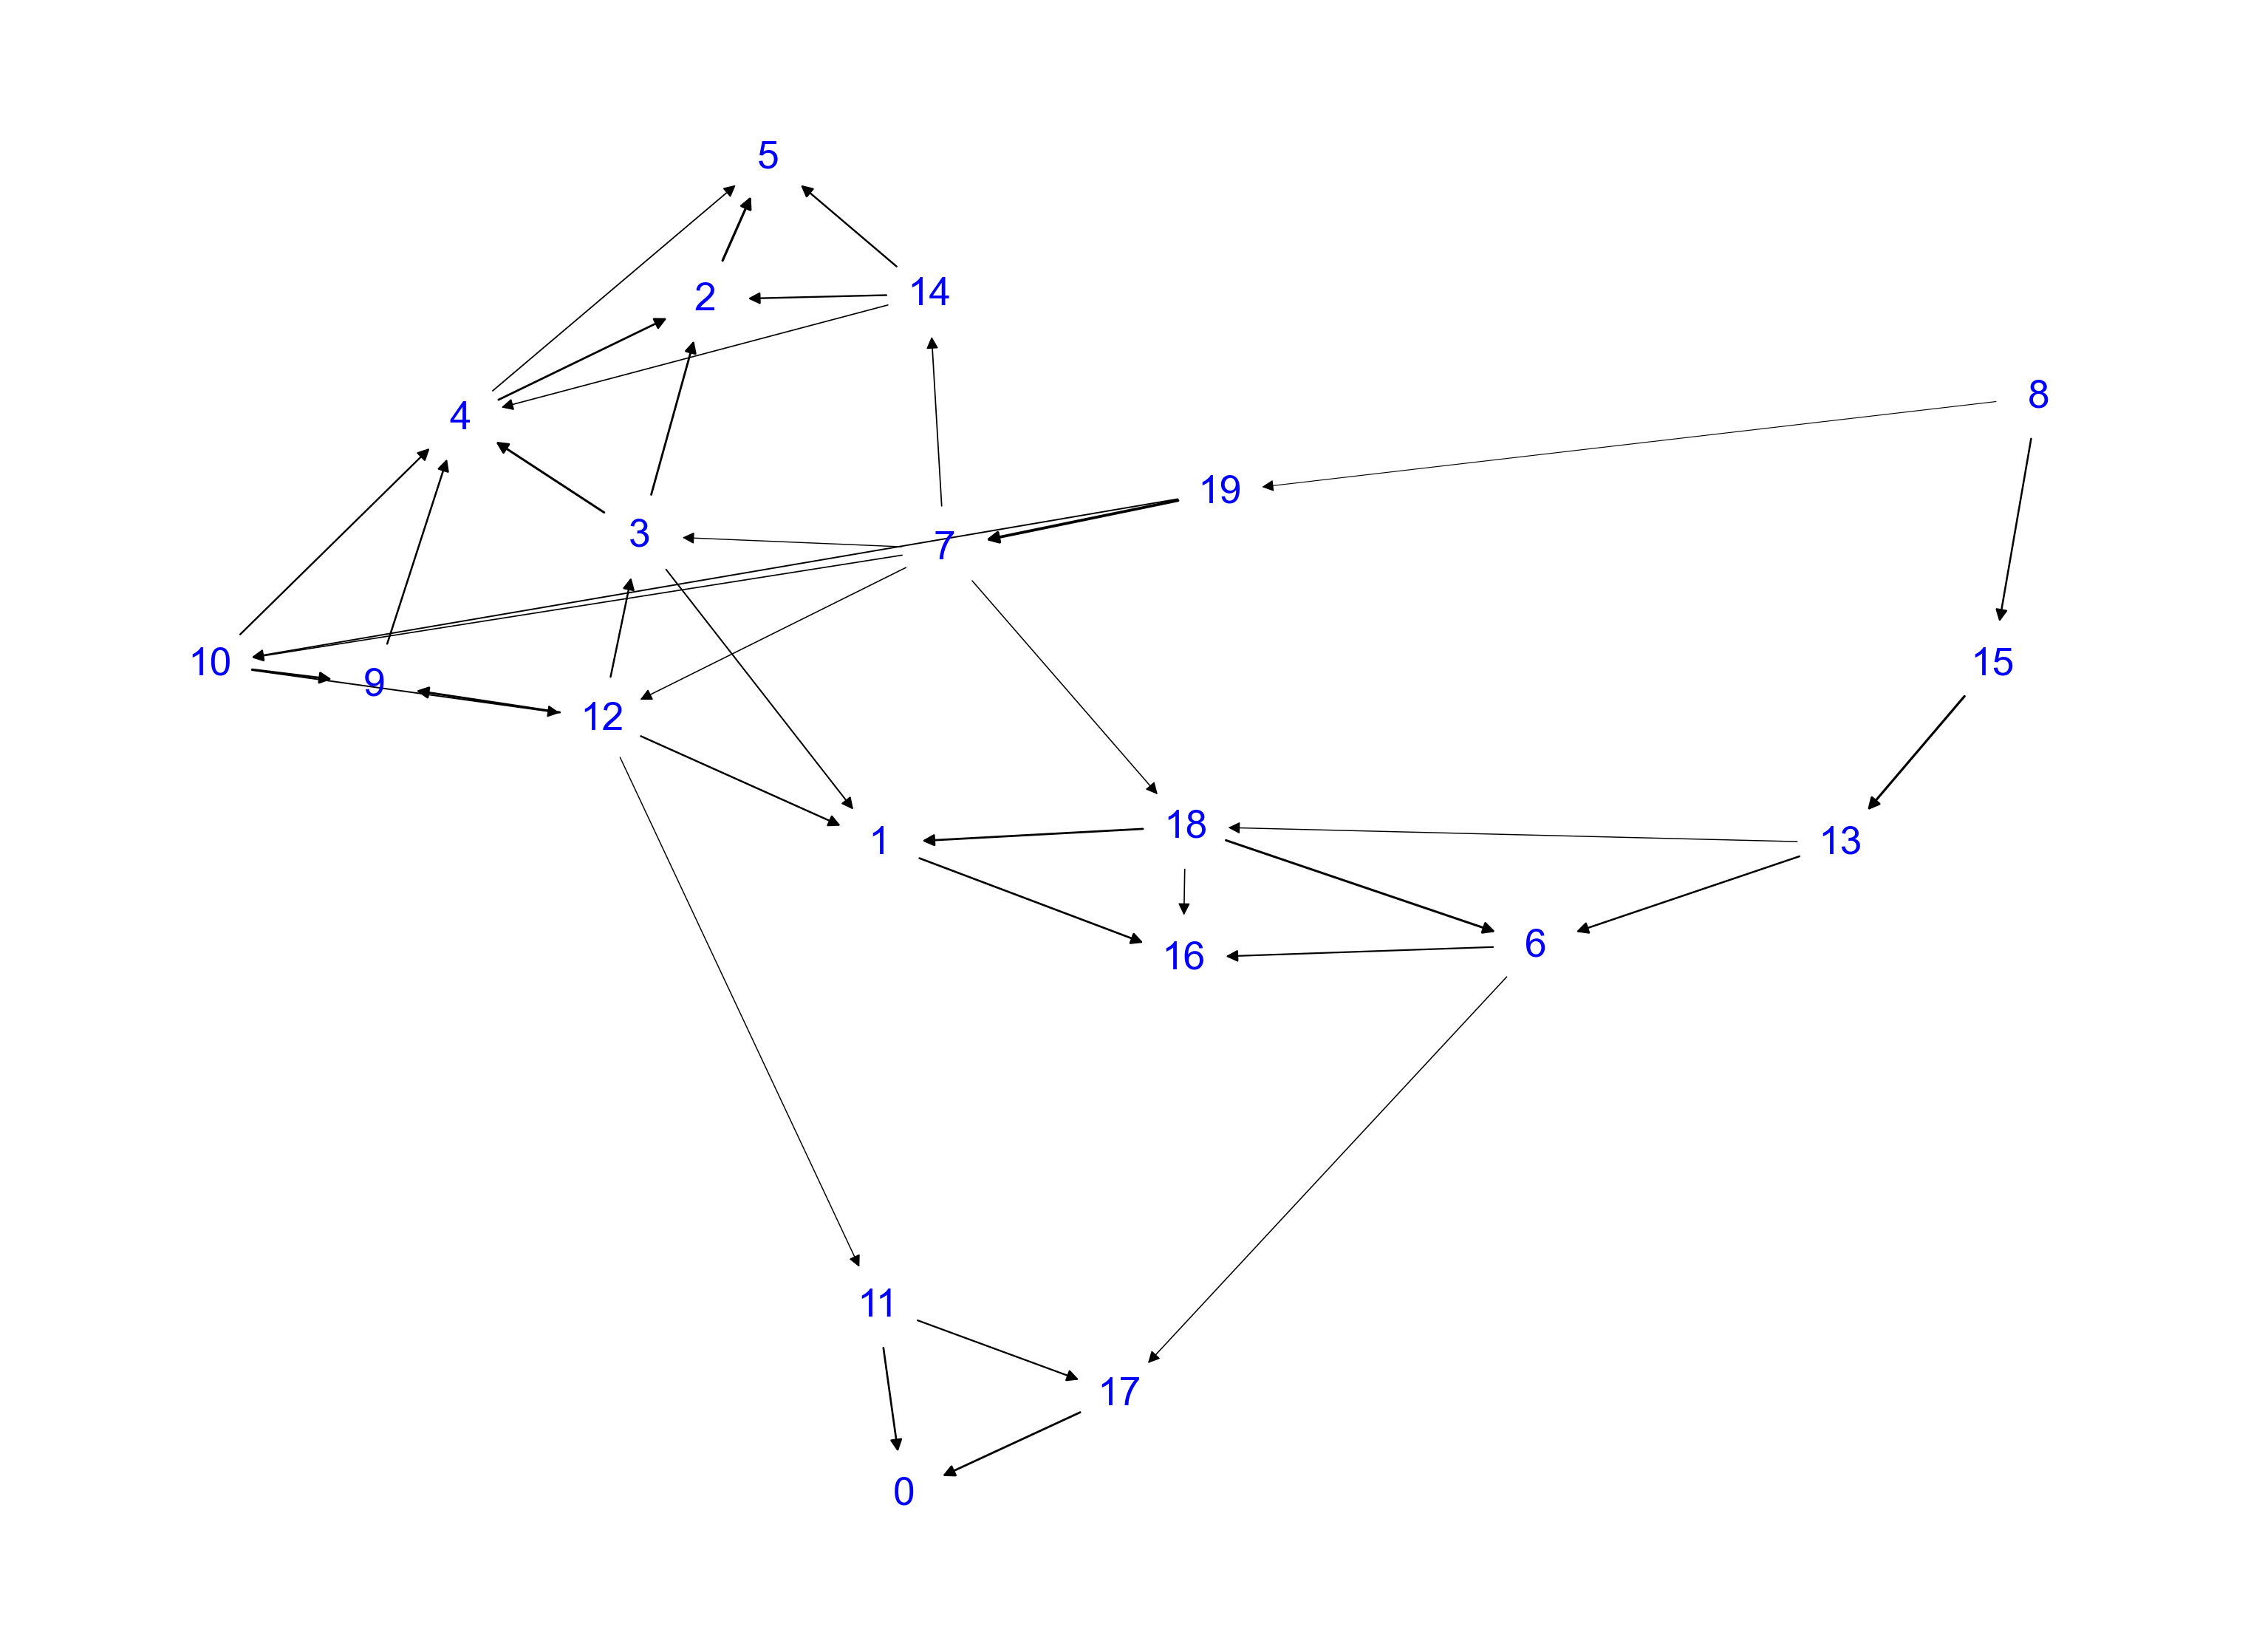

In [59]:
from utils.plot import plot_graph

g = nx.from_pandas_adjacency(G_directed_v2, create_using=nx.DiGraph)

print(g.nodes())

node_keys = list(node_positions.keys())  # Should be the same as g.nodes()
colors = [color_map[node] for node in node_keys if node in color_map]

plot_graph(
    g,
    node_positions=node_positions,
    figsize=(16, 12),
    offset=0.2,
    node_color=colors,
    font_size=16,
    font_color='blue',
    node_size=1200
)

In [60]:
print(g)

DiGraph with 20 nodes and 38 edges


In [61]:
from models.ti.downstream import (
    get_terminal_states,
    get_terminal_cells,
    sample_waypoints,
    compute_diff_potential,
)

In [62]:
X = preprocessed_data.obsm['metric_embedding']

n_neighbors = 50
nbrs = NearestNeighbors(n_neighbors=n_neighbors, metric="euclidean").fit(X)
adj_dist = nbrs.kneighbors_graph(X, mode="distance")
adj_conn = nbrs.kneighbors_graph(X)

In [63]:
# Terminal state computation

get_terminal_states(preprocessed_data, G_directed_v2, start_cell_ids, mad_multiplier=0.5)

Terminal cluster candidate 1: {0, 16, 5}
Terminal cluster candidate 2: {0, 2, 5, 8, 9, 16}
Terminal clusters: {0, 16, 2, 5, 9}


{0, 2, 5, 9, 16}

In [64]:
# Ensure terminal states are computed before accessing terminal cells
if 'metric_terminal_clusters' not in preprocessed_data.uns:
	start_cell_ids = preprocessed_data.uns['start_id']
	get_terminal_states(preprocessed_data, G_directed_v2, start_cell_ids, mad_multiplier=0.5)

# Terminal cell computation
t_cell_ids = get_terminal_cells(preprocessed_data)
t_cell_ids

['C1-1772117-151-H08',
 'C1-1772099-014-C08',
 'C1-1772099-015-C06',
 'C1-1772099-012-H12',
 'C1-1772117-111-C11']

In [65]:
# Waypoint computation
from models.ti.downstream import sample_waypoints


dists, wp = sample_waypoints(preprocessed_data, adj_dist.todense(), n_waypoints=30)

/home/satwik/Desktop/presentation/models/ti/downstream.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dists.loc[cell_ids, k] = v
/home/satwik/Desktop/presentation/models/ti/downstream.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dists.loc[cell_ids, k] = v
/home/satwik/Desktop/presentation/models/ti/downstream.py:241: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

In [66]:
# Compute entropy and diff potential

ent, bps = compute_diff_potential(
    preprocessed_data,
    adj_dist.todense(),
    adj_cluster,
    std_factor=0,
    prune_wp_graph=True
)

Cell to Waypoint connectivity
Waypoint to Terminal State connectivity
Markov chain construction...
Computing fundamental matrix and absorption probabilities...


/home/satwik/dynooenv/lib/python3.12/site-packages/scipy/stats/_entropy.py:133: RuntimeWarning: invalid value encountered in divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


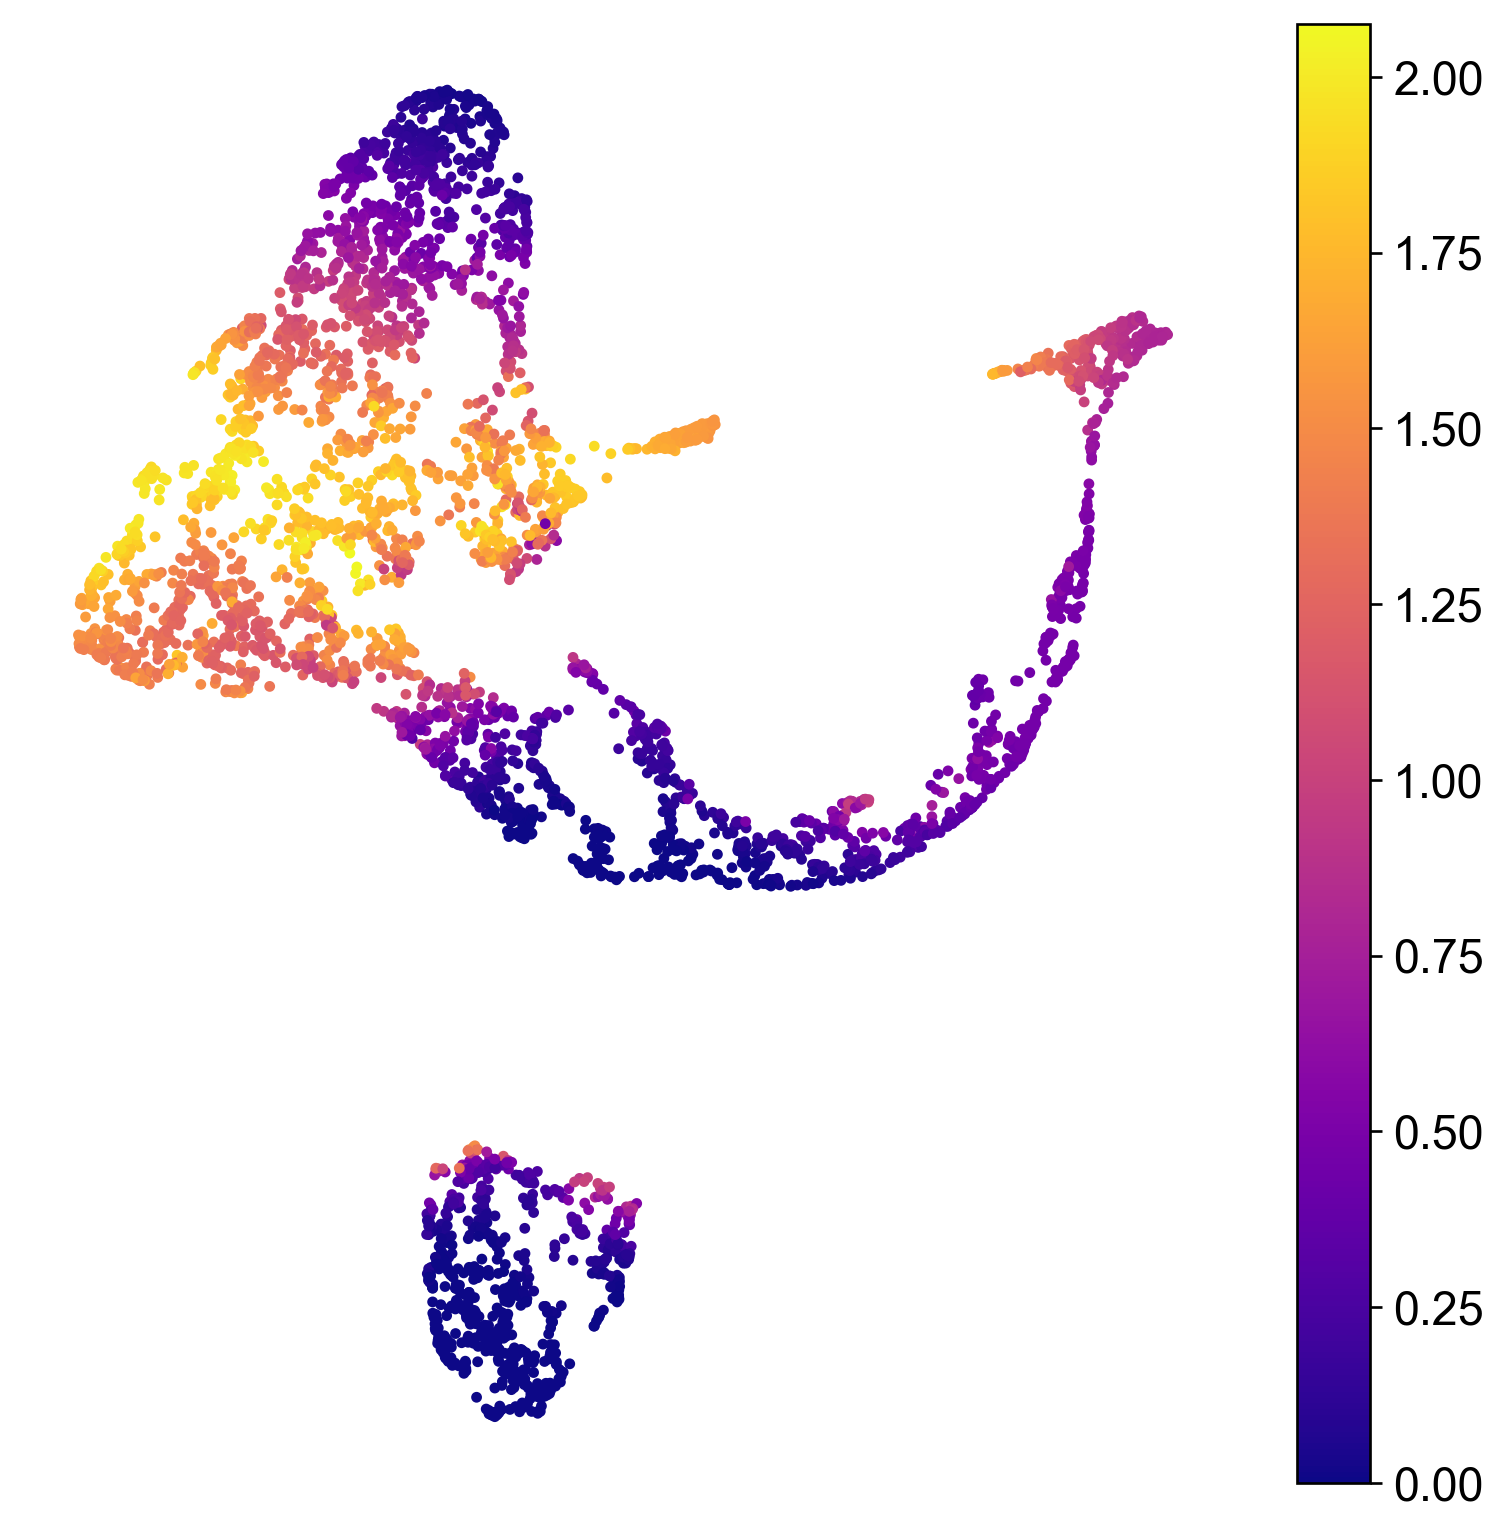

In [67]:
# Plot the Differentiation potential
plot_embeddings(
    preprocessed_data.obsm['X_met_embedding'],
    s=5,
    c=ent,
    figsize=(8, 8),
    cmap='plasma',
    show_colorbar=True
)

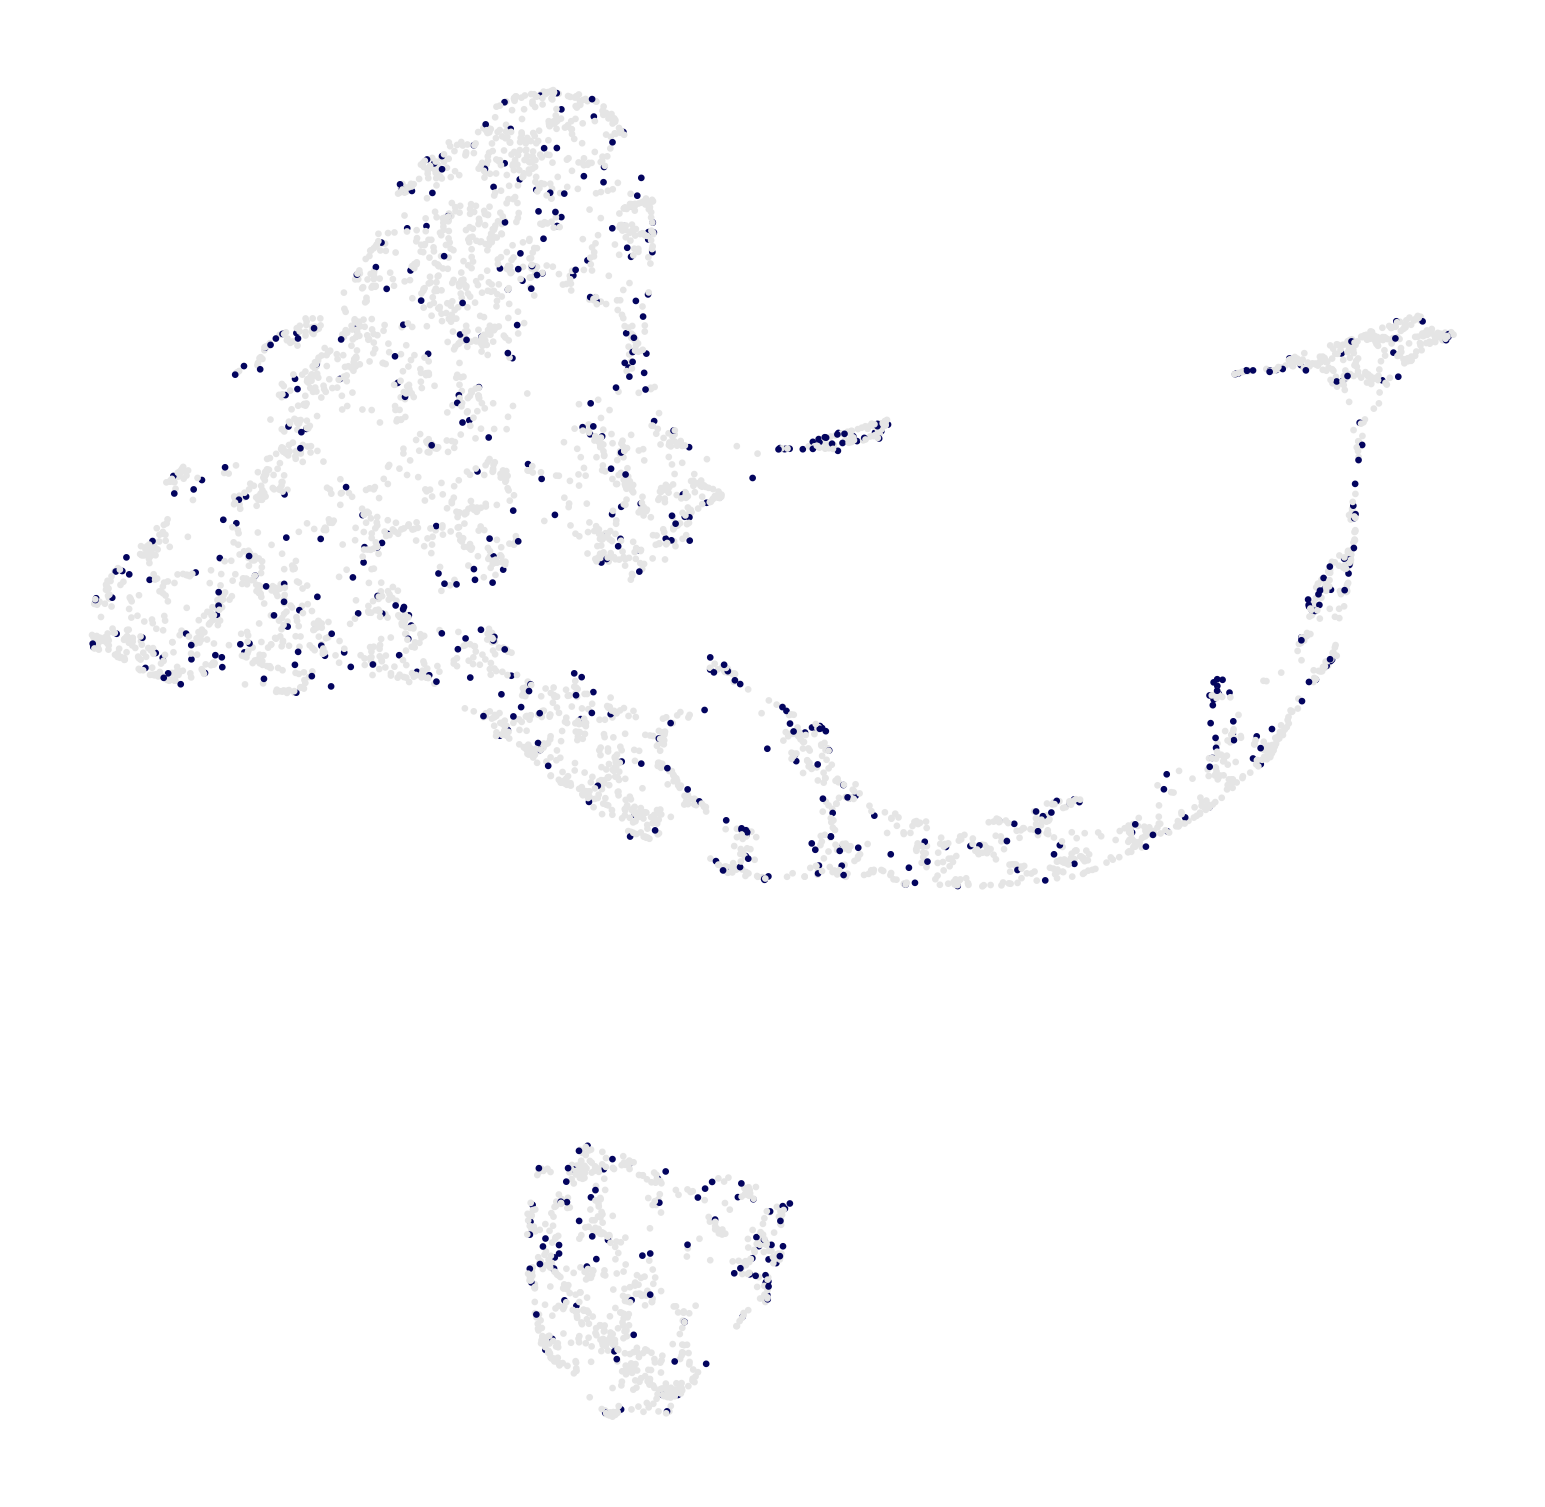

In [68]:
# Plot the sampled waypoints
colors = ['#03045E' if cell_id in preprocessed_data.uns['metric_waypoints'] else '#E5E5E5' for cell_id in preprocessed_data.obs_names]
plot_embeddings(
    preprocessed_data.obsm['X_met_embedding'],
    s=1,
    c=colors,
    figsize=(8, 8)
)

In [69]:
import scipy.stats as ss

ss.spearmanr(preprocessed_data.obs['metric_dp'], adata.uns['timecourse']['pt'])

SignificanceResult(statistic=0.29571863499428797, pvalue=4.537288110696615e-100)

# Margaret metrics

In [70]:
cell_ids = preprocessed_data.obs_names.tolist()
m_pseudotime = preprocessed_data.obs['metric_pseudotime_v2']
m_pseudotime.name = 'pseudotime'
m_milestone_ids = sorted(preprocessed_data.obs['metric_clusters'].unique())
m_milestone_ids = [str(i) for i in m_milestone_ids]
m_milestone_percentages = pd.DataFrame({'cell_id': cell_ids, 'milestone_id': list(preprocessed_data.obs['metric_clusters']), 'percentage': [1 for i in range(len(cell_ids))]})
m_milestone_percentages['milestone_id'] = m_milestone_percentages['milestone_id'].astype(str)
m_milestone_percentages

cell_id milestone_id  percentage
0     C1-1771017-028-D03            8           1
1     C1-1771017-028-E03            8           1
2     C1-1771017-028-F08            8           1
3     C1-1771017-028-G05            8           1
4     C1-1771017-028-G10            8           1
...                  ...          ...         ...
4925  C1-1862091-118-C05            6           1
4926  C1-1862091-118-C07           11           1
4927  C1-1862091-118-D10            6           1
4928  C1-1862091-118-E08           17           1
4929  C1-1862091-118-F09            6           1

[4930 rows x 3 columns]

In [71]:
G = nx.from_pandas_adjacency(G_directed_v2, create_using=nx.DiGraph)
m_edges_df = nx.to_pandas_edgelist(G).rename(columns={'source': 'from', 'target': 'to'})
m_edges_df['length'] = 1  # no weights stored, use default for now
m_edges_df['directed'] = True
m_edges_df['from'] = m_edges_df['from'].astype(str)
m_edges_df['to'] = m_edges_df['to'].astype(str)
del m_edges_df['weight']
m_edges_df

from  to  length  directed
0     1  16       1      True
1     2   5       1      True
2     3   1       1      True
3     3   2       1      True
4     3   4       1      True
5     4   2       1      True
6     4   5       1      True
7     6  16       1      True
8     6  17       1      True
9     7   3       1      True
10    7  10       1      True
11    7  12       1      True
12    7  14       1      True
13    7  18       1      True
14    8  15       1      True
15    8  19       1      True
16    9   4       1      True
17   10   4       1      True
18   10   9       1      True
19   10  12       1      True
20   11   0       1      True
21   11  17       1      True
22   12   1       1      True
23   12   3       1      True
24   12   9       1      True
25   12  11       1      True
26   13   6       1      True
27   13  18       1      True
28   14   2       1      True
29   14   4       1      True
30   14   5       1      True
31   15  13       1      True
32   17   0       1      True
33   18   1       1      True
34   18   6       1      True
35   18  16       1      True
36   19   7       1      True
37   19  10       1      True

In [72]:
disconnected = set(m_milestone_ids)
for i in m_edges_df['from']:
    disconnected.discard(i)
for i in m_edges_df['to']:  
    disconnected.discard(i)
disconnected = list(disconnected)
disconnected

[]

In [73]:
# new_rows = [{'from': i, 'to': i, 'length': 0, 'directed': True} for i in disconnected]
# m_edges_df = pd.concat([m_edges_df, pd.DataFrame(new_rows)], ignore_index=True)
# m_edges_df

In [74]:
# m_milestone_percentages.percentage.value_counts()

In [75]:
# progressions = pd.DataFrame({
#     'cell_id': cell_ids,
#     'from': [1 for i in range(len(cell_ids))],
#     'to': [1 for i in range(len(cell_ids))],
#     'percentage': [1 for i in range(len(cell_ids))]
# })
# progressions

In [76]:
# cell_to_milestone = dict(zip(m_milestone_percentages['cell_id'], m_milestone_percentages['milestone_id']))
# progressions['milestone'] = progressions['cell_id'].map(cell_to_milestone)
# progressions

In [77]:
# import random

# # Iterate through each row in the progressions DataFrame
# for idx, row in progressions.iterrows():
#     milestone = row['milestone']
    
#     # Filter rows in the milestone_network (m_edges_df) where the milestone is in 'from' or 'to'
#     matching_rows = m_edges_df[(m_edges_df['from'] == milestone) | (m_edges_df['to'] == milestone)]
    
#     # Pick one row at random from the matching rows
#     selected_row = matching_rows.sample(n=1).iloc[0]
    
#     # Update the 'from' and 'to' columns in progressions
#     progressions.at[idx, 'from'] = selected_row['from']
#     progressions.at[idx, 'to'] = selected_row['to']
    
#     # Update the 'percentage' column based on whether the milestone was in 'from' or 'to'
#     if selected_row['from'] == milestone:
#         progressions.at[idx, 'percentage'] = 0
#     elif selected_row['to'] == milestone:
#         progressions.at[idx, 'percentage'] = 1

# progressions

In [78]:
# progressions.percentage.value_counts()

In [79]:
# del progressions['milestone']

In [80]:
%%R -i cell_ids -i m_pseudotime -i m_milestone_ids -i m_milestone_percentages -i m_edges_df

m_dataset <- readRDS("oligodendrocyte-differentiation-subclusters_marques(1).rds")

marg_traj <- add_trajectory(
    m_dataset,
    cell_ids = cell_ids,
    pseudotime = m_pseudotime,
    milestone_ids = m_milestone_ids,
    milestone_percentages = m_milestone_percentages,
    milestone_network = m_edges_df,
)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


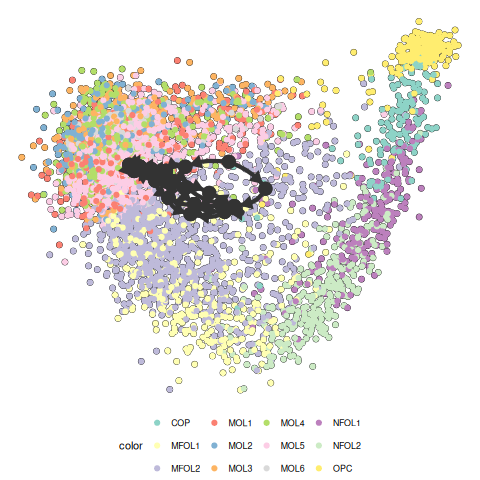

In [81]:
%%R
plot_dimred(marg_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

In [78]:
# %%R
# marg_traj$milestone_network <- marg_traj$milestone_network[marg_traj$milestone_network$length != 0, ]
# marg_traj$milestone_network

In [180]:
%%R
marg_metrics <- calculate_metrics(
  dataset = m_dataset,
  model = marg_traj,
  metrics = dyneval::metrics$metric_id,
  expression_source = m_dataset$expression
)

In [80]:
%%R
cat("HIM =", marg_metrics$him, "\n")
cat("F1_branches =", marg_metrics$F1_branches, "\n")
cat("correlation =", marg_metrics$correlation, "\n")
cat("featureimp_wcor =", marg_metrics$featureimp_wcor, "\n")
m_selected_metrics <- c(
  him = as.numeric(marg_metrics$him),
  F1_branches = marg_metrics$F1_branches,
  correlation = marg_metrics$correlation,
  featureimp_wcor = marg_metrics$featureimp_wcor
)
m_overall_score <- exp(mean(log(m_selected_metrics)))
cat("overall_score =", m_overall_score, "\n")

HIM = 0.5208551 
F1_branches = 0.1014899 
correlation = 0.4335274 
featureimp_wcor = 0.8389517 
overall_score = 0.3723688 


# Palantir

In [81]:
import scanpy as sc
import palantir

%matplotlib inline

In [82]:
ad = adata.copy()
# sc.pp.normalize_per_cell(ad)

# from utils.util import log_transform

# log_transform(ad, pseudo_count=0.1)
# sc.pp.highly_variable_genes(ad, n_top_genes=1500, flavor='cell_ranger')
pca_projections, _ = palantir.utils.run_pca(ad, use_hvg=False)
dm_res = palantir.utils.run_diffusion_maps(pca_projections, n_components=10)
ms_data = palantir.utils.determine_multiscale_space(dm_res)

In [83]:
from utils.plot import generate_plot_embeddings, plot_embeddings

In [84]:
X_dm = generate_plot_embeddings(ms_data, perplexity=150, method='tsne', random_state=0)

Runtime for generate_plot_embeddings(): 24.024229764938354


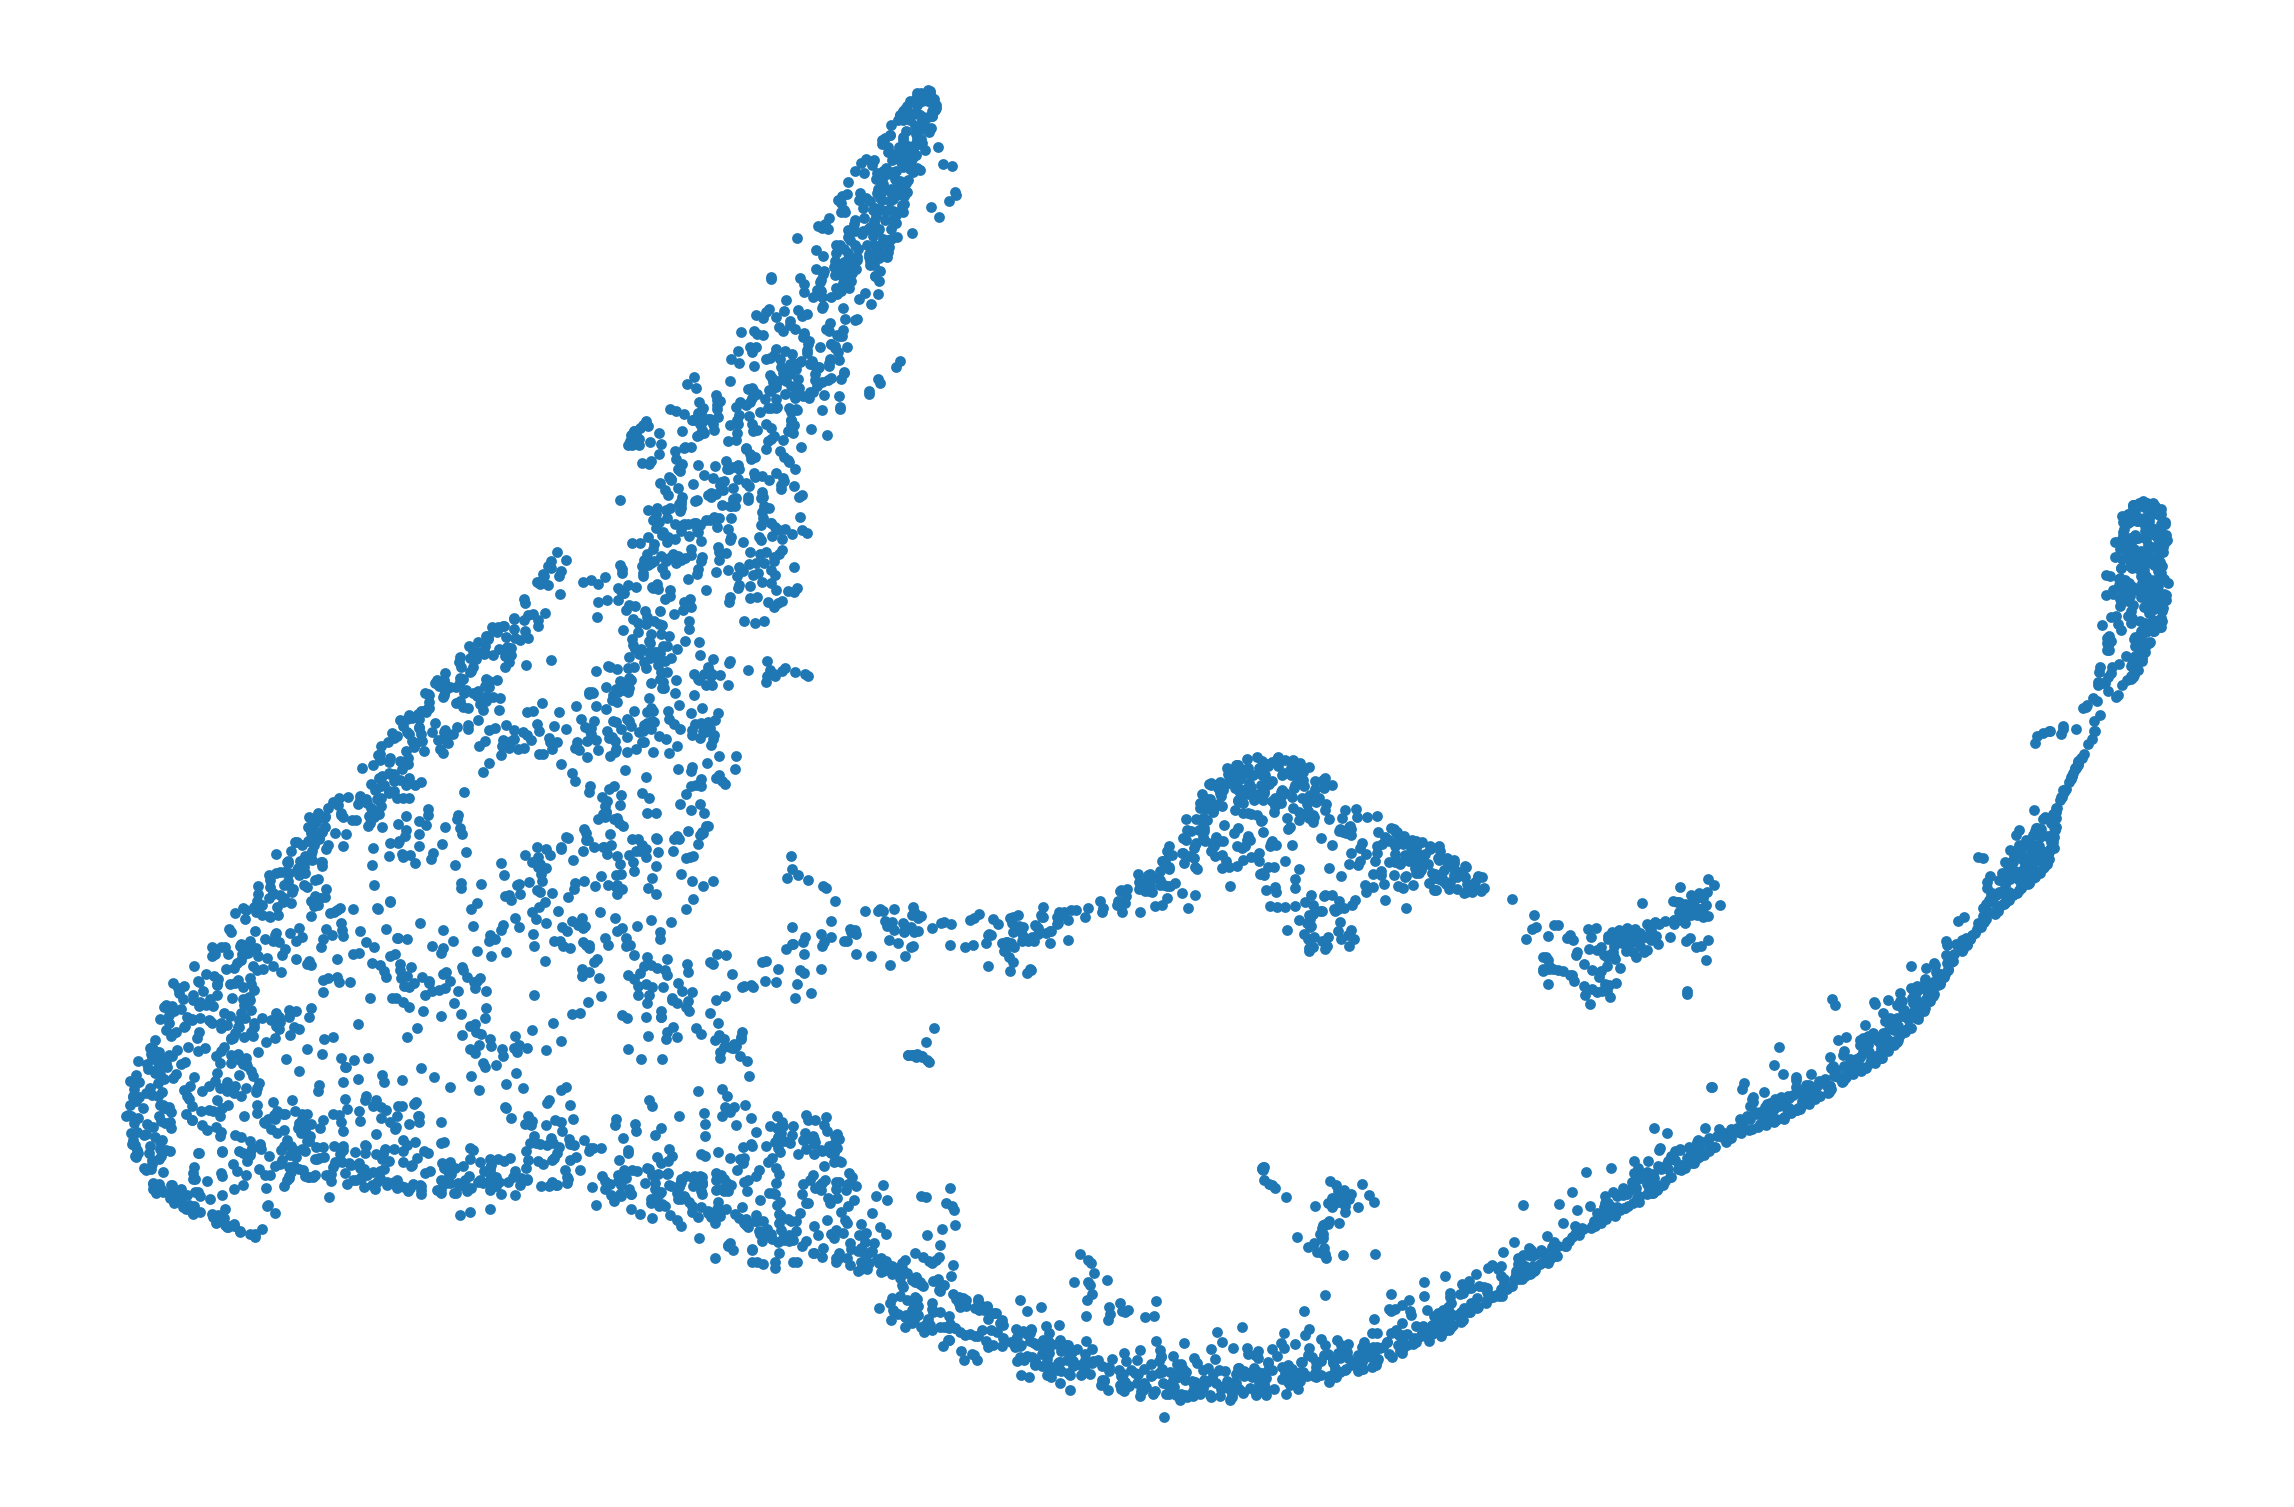

In [85]:
plot_embeddings(X_dm, s=5)

In [86]:
ad.uns['start_id']

'C1-1771051-158-E04'

In [87]:
early_cell = ad.uns['start_id']
# early_cell = ad.uns['start_id'][1]
presults = palantir.core.run_palantir(ms_data, early_cell)

Sampling and flocking waypoints...
Time for determining waypoints: 0.01076430877049764 minutes
Determining pseudotime...
Shortest path distances using 30-nearest neighbor graph...
Time for shortest paths: 0.6036954243977865 minutes
Iteratively refining the pseudotime...
Correlation at iteration 1: 0.9995
Correlation at iteration 2: 0.9999
Entropy and branch probabilities...
Markov chain construction...
Identification of terminal states...
Computing fundamental matrix and absorption probabilities...
Project results to all cells...


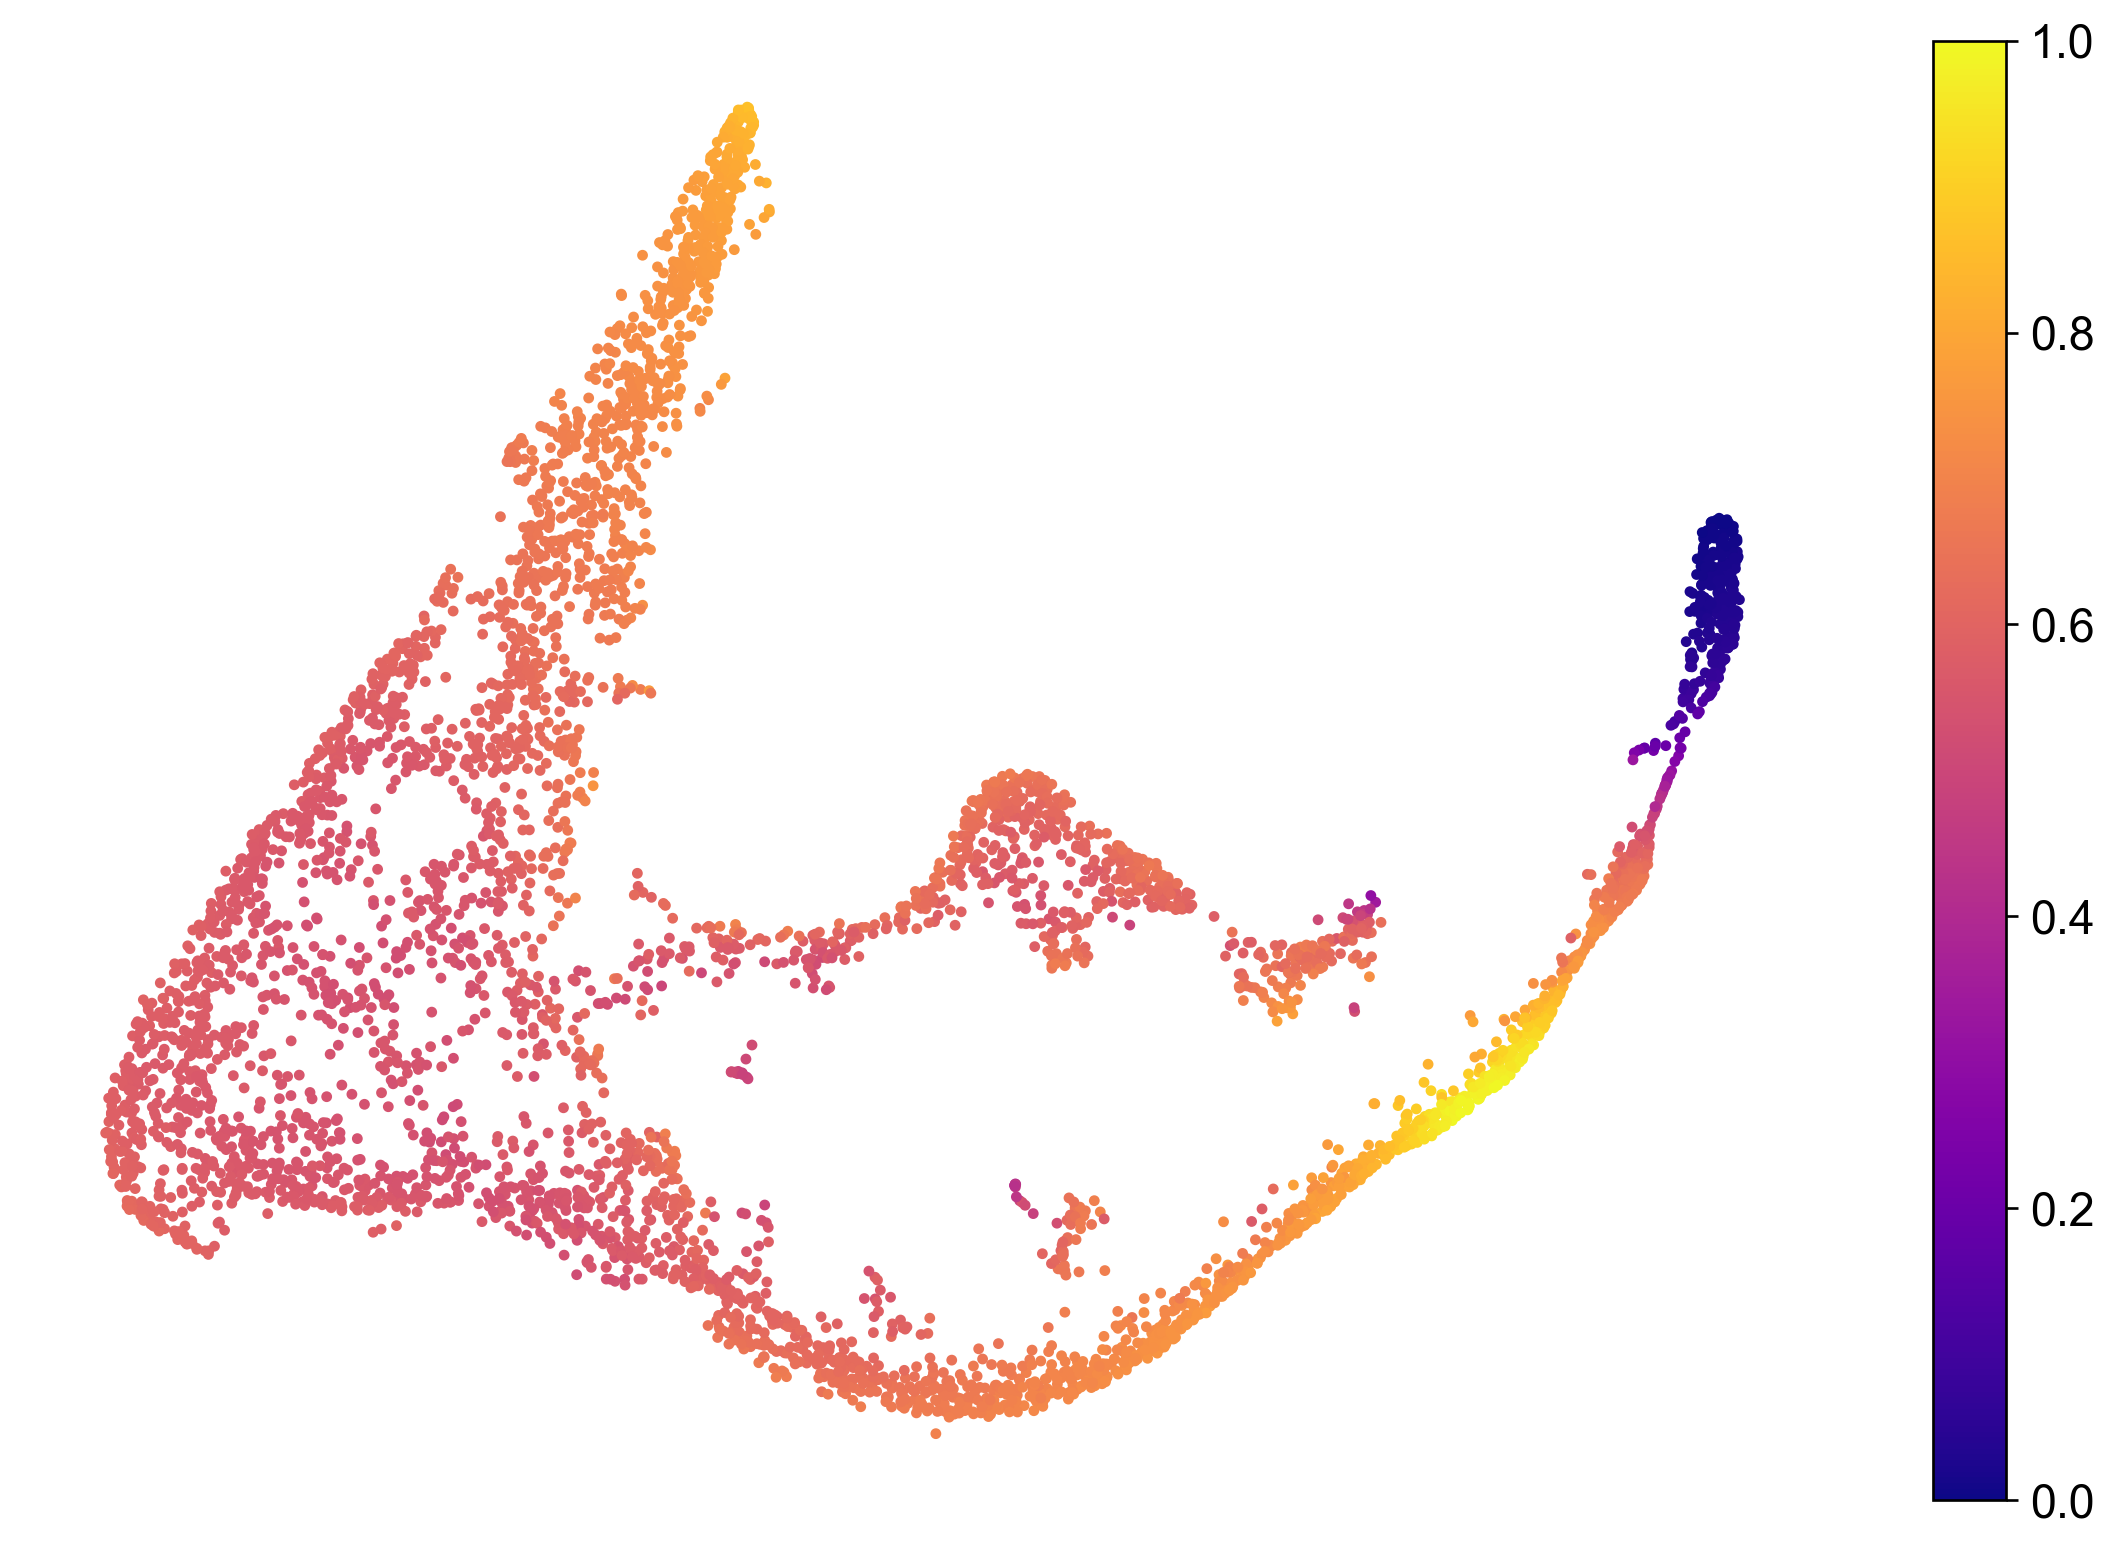

In [88]:
plot_embeddings(
    X_dm,
    s=5,
    c=presults.pseudotime,
    cmap='plasma',
    show_colorbar=True
)

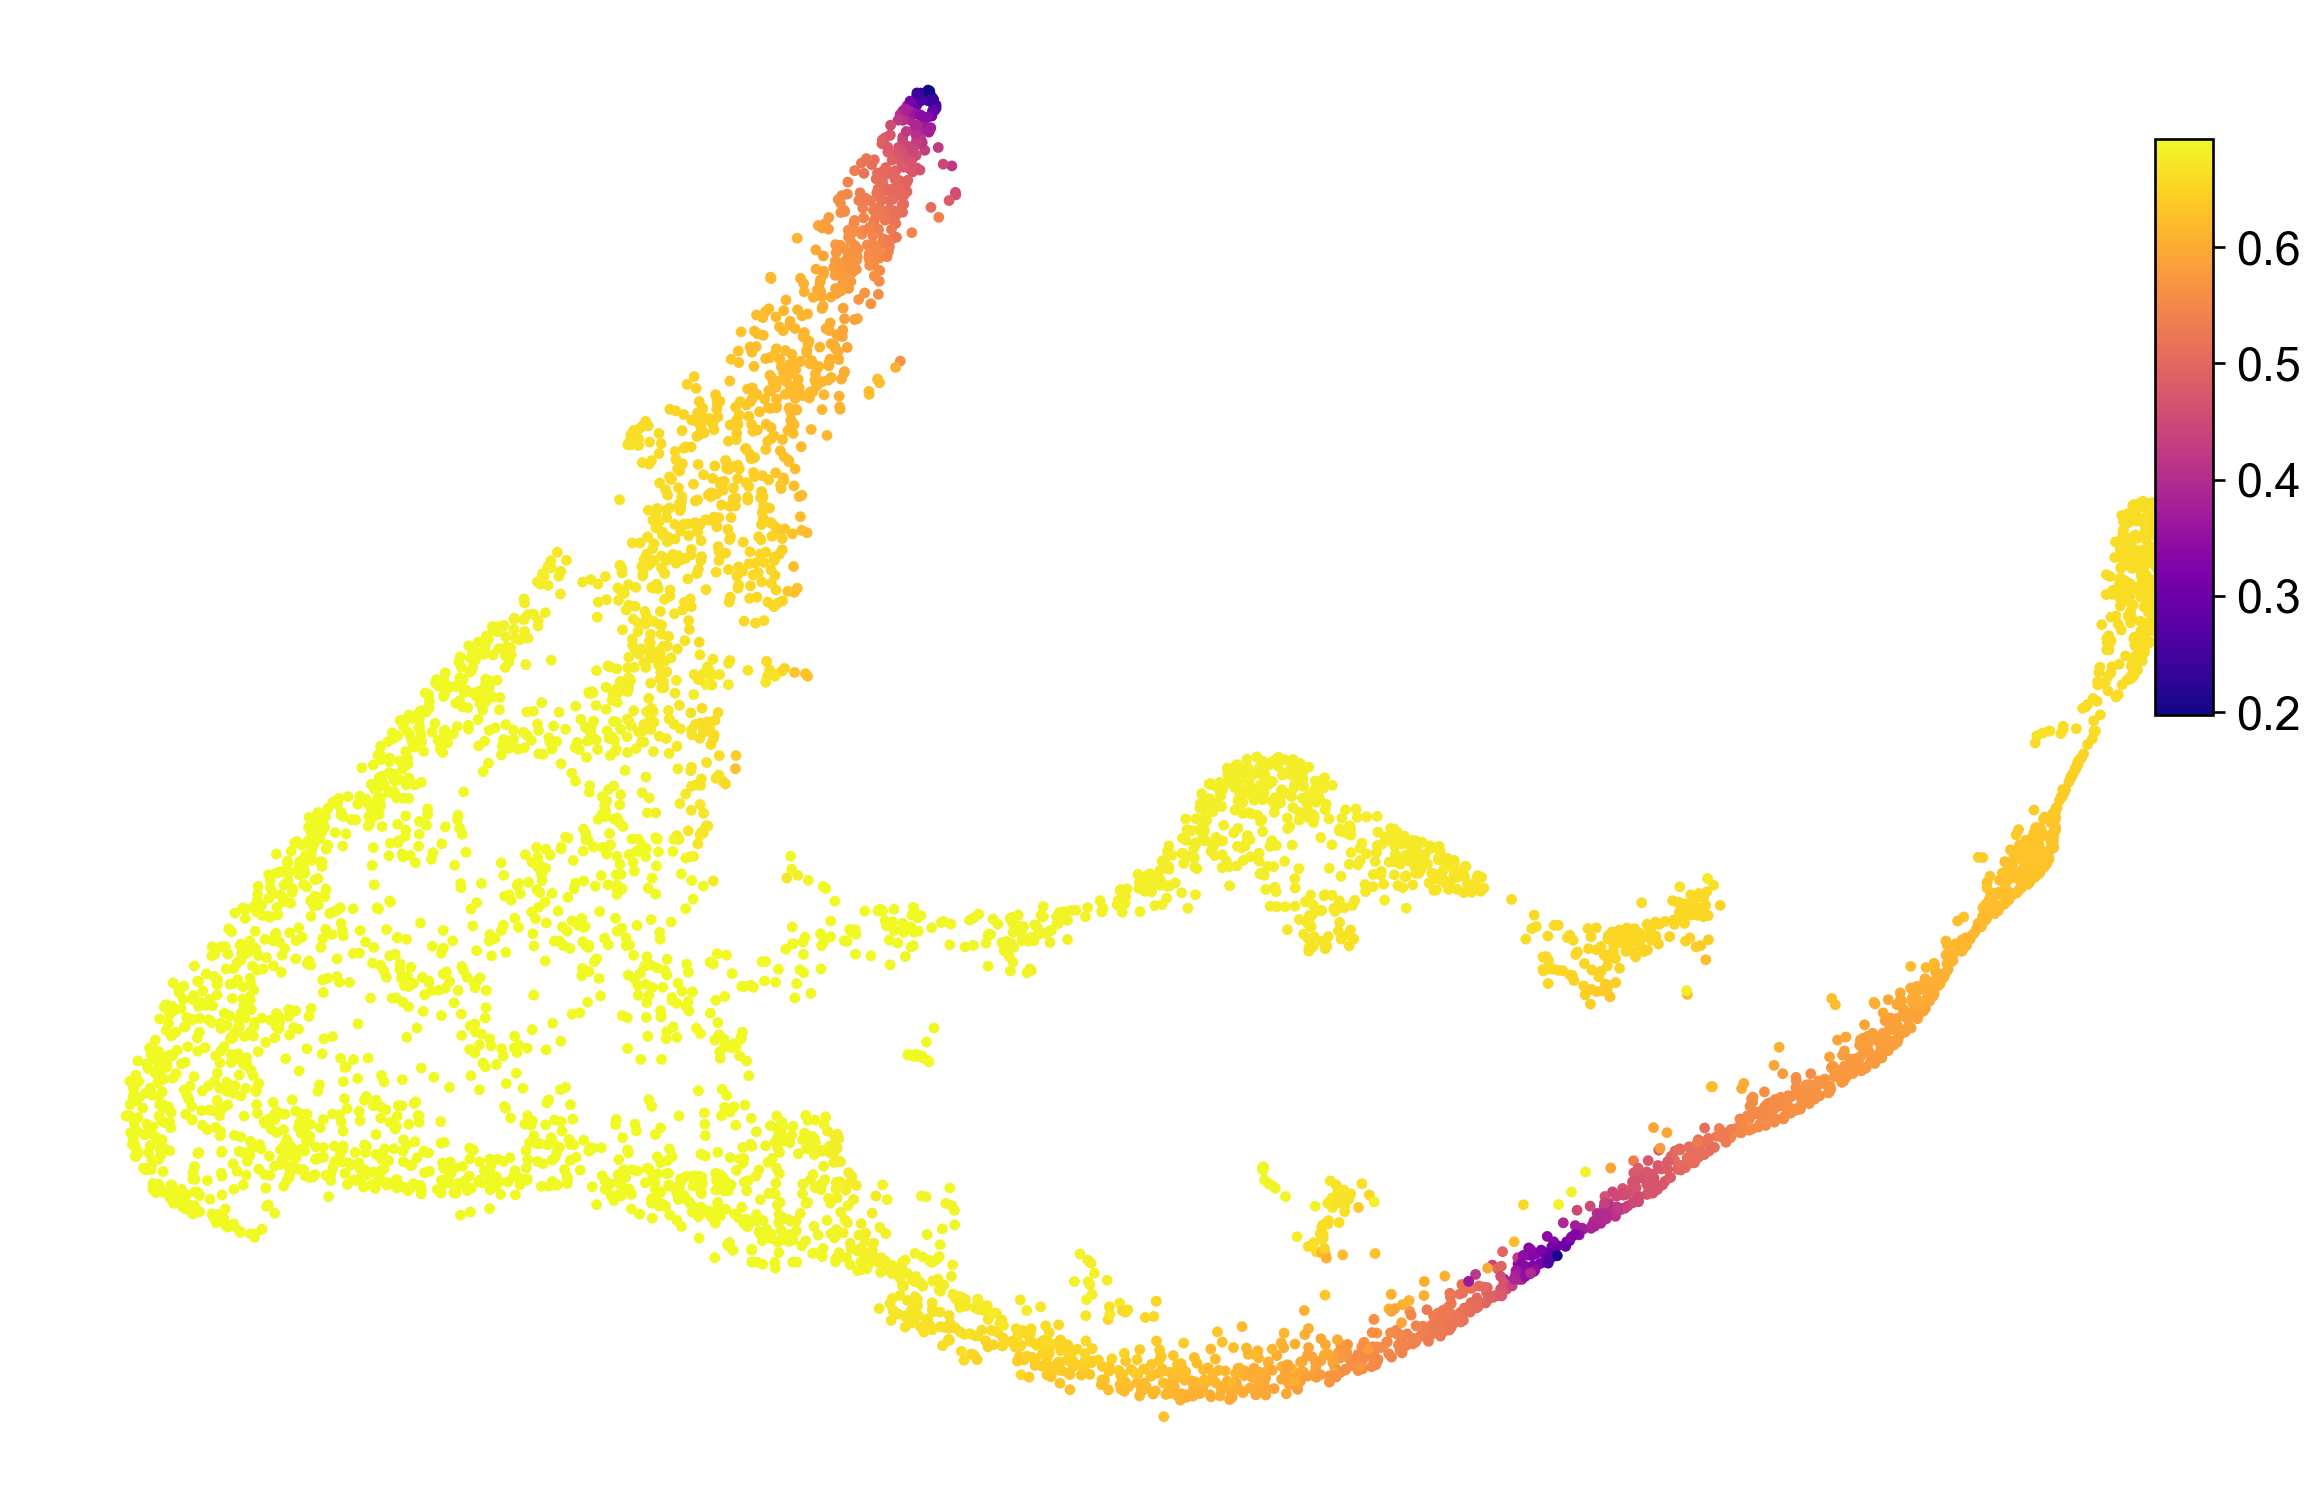

In [89]:
plot_embeddings(
    X_dm,
    s=5,
    c=presults.entropy,
    cmap='plasma',
    show_colorbar=True,
    cb_axes_pos=[0.92, 0.55, 0.02, 0.3]
)

In [90]:
import scipy.stats as ss

ss.spearmanr(presults.entropy, adata.uns['timecourse']['pt'])

SignificanceResult(statistic=0.4819494202878731, pvalue=3.3018243743768976e-285)

# Palantir metrics

In [91]:
pal_pseudotime = presults.pseudotime
pal_branch_probs = presults.branch_probs
pal_branch_probs

C1-1772096-116-G08  C1-1772099-073-C03
C1-1771017-028-D03            0.375248            0.624752
C1-1771017-028-E03            0.375248            0.624752
C1-1771017-028-F08            0.375248            0.624752
C1-1771017-028-G05            0.375248            0.624752
C1-1771017-028-G10            0.375248            0.624752
...                                ...                 ...
C1-1862091-118-C05            0.097921            0.902079
C1-1862091-118-C07            0.384382            0.615618
C1-1862091-118-D10            0.249665            0.750335
C1-1862091-118-E08            0.364637            0.635363
C1-1862091-118-F09            0.248932            0.751068

[4930 rows x 2 columns]

In [92]:
pal_branch_probs.reset_index(inplace=True)
pal_branch_probs.rename(columns={'index': 'cell_id'}, inplace=True)
pal_branch_probs

cell_id  C1-1772096-116-G08  C1-1772099-073-C03
0     C1-1771017-028-D03            0.375248            0.624752
1     C1-1771017-028-E03            0.375248            0.624752
2     C1-1771017-028-F08            0.375248            0.624752
3     C1-1771017-028-G05            0.375248            0.624752
4     C1-1771017-028-G10            0.375248            0.624752
...                  ...                 ...                 ...
4925  C1-1862091-118-C05            0.097921            0.902079
4926  C1-1862091-118-C07            0.384382            0.615618
4927  C1-1862091-118-D10            0.249665            0.750335
4928  C1-1862091-118-E08            0.364637            0.635363
4929  C1-1862091-118-F09            0.248932            0.751068

[4930 rows x 3 columns]

In [93]:
%%R -i pal_pseudotime -i pal_branch_probs
pal_dataset <- readRDS("oligodendrocyte-differentiation-subclusters_marques(1).rds")
pal_traj <- add_end_state_probabilities(
  pal_dataset,
  end_state_probabilities = pal_branch_probs,
  pseudotime = pal_pseudotime,
)

In [177]:
%%R
pal_metrics <- calculate_metrics(
  dataset = pal_dataset,
  model = pal_traj,
  metrics = c('rf_mse', 'rf_nmse', 'rf_rsq', 'lm_nmse', 'lm_mse', 'lm_rsq', 'edge_flip', 'him', 'isomorphic', 'featureimp_cor', 'featureimp_wcor', 'featureimp_ks', 'featureimp_wilcox', 'F1_branches', 'F1_milestones', 'harm_mean', 'geom_mean', 'arith_mean'),
  expression_source = pal_dataset$expression
)

In [178]:
%%R
cat("HIM =", pal_metrics$him, "\n")
cat("F1_branches =", pal_metrics$F1_branches, "\n")
# cat("correlation =", pal_metrics$correlation, "\n")
cat("featureimp_wcor =", pal_metrics$featureimp_wcor, "\n")
pal_selected_metrics <- c(
  him = as.numeric(pal_metrics$him),
  F1_branches = pal_metrics$F1_branches,
  # correlation = pal_metrics$correlation,
  featureimp_wcor = pal_metrics$featureimp_wcor
)
pal_overall_score <- exp(mean(log(pal_selected_metrics)))
cat("overall_score =", pal_overall_score, "\n")

HIM = 0.2688911 
F1_branches = 0.3321286 
featureimp_wcor = 0.7249645 
overall_score = 0.401544 


In [ ]:
%%R
# plot_dimred(pal_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

NULL


# paga

In [82]:
import scanpy as sc

In [83]:
# data_path = '/content/drive/MyDrive/project_margaret/simulated/multifurcating/dyntoy_multifurcating_gen_5.h5ad'
# ad = sc.read(data_path)
ad = adata.copy()

In [84]:
# from utils.util import preprocess_recipe

# # Preprocessing using Seurat default parameters
# min_expr_level = 3
# min_cells = None
# use_hvg = False
# n_top_genes = 720
# preprocessed_data = preprocess_recipe(
#     ad,
#     min_expr_level=min_expr_level,
#     min_cells=min_cells,
#     use_hvg=use_hvg,
#     n_top_genes=n_top_genes,
#     scale=True
# )

In [85]:
from utils.util import run_pca

# Apply PCA on the raw data for initial denoising
print('Computing PCA...')
X_pca, _, n_comps = run_pca(preprocessed_data, use_hvg=False, n_components=50)
preprocessed_data.obsm['X_pca'] = X_pca
print(f'Components computed: {n_comps}')

Computing PCA...
Runtime for run_pca(): 2.4447875022888184
Components computed: 50


In [86]:
sc.pp.neighbors(preprocessed_data, n_neighbors=15)

In [87]:
sc.tl.umap(preprocessed_data, n_components=2, min_dist=0.1)

In [88]:
sc.pp.neighbors(preprocessed_data, n_neighbors=20, use_rep='X_umap', key_added='knn_umap')

In [89]:
sc.tl.leiden(preprocessed_data, random_state=0, resolution=1.0, neighbors_key='knn_umap')

/tmp/ipykernel_977381/2546193246.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(preprocessed_data, random_state=0, resolution=1.0, neighbors_key='knn_umap')


In [90]:
sc.tl.paga(preprocessed_data, neighbors_key='knn_umap')

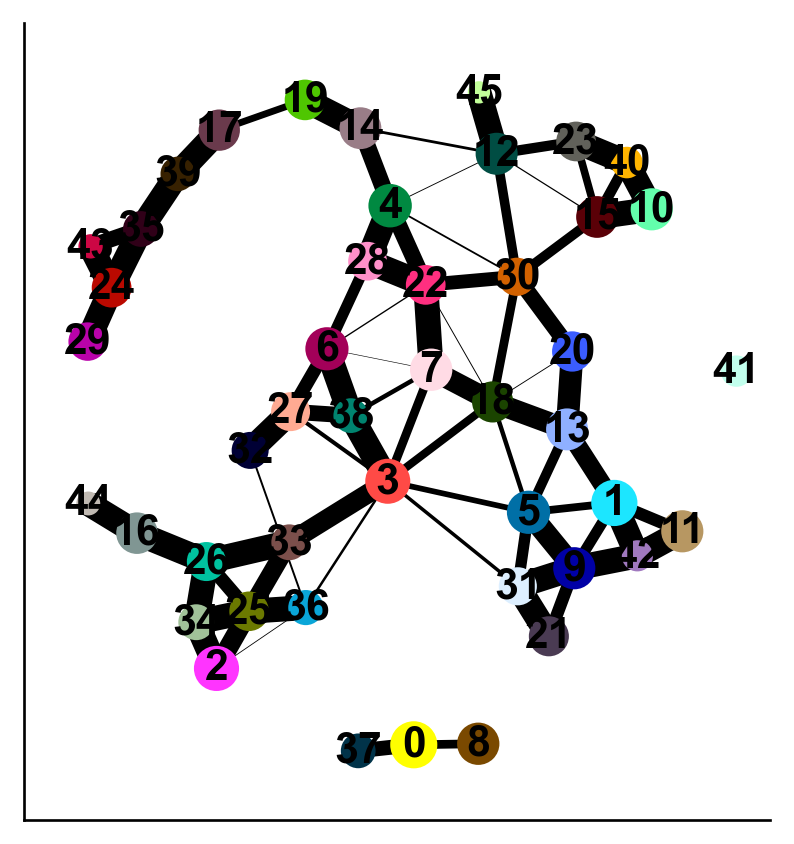

In [91]:
sc.pl.paga(preprocessed_data, save='mono3_d4.png')

In [92]:
import networkx as nx
from models.ti.graph import compute_gt_milestone_network

paga_conns = np.array(preprocessed_data.uns['paga']['connectivities'].todense())
paga_conns_filtered = (paga_conns > 0.05).astype(int)
g = nx.from_numpy_array(paga_conns_filtered)
gt = compute_gt_milestone_network(preprocessed_data, mode='undirected')

Runtime for compute_gt_milestone_network(): 0.0005657672882080078


In [93]:
from metrics.ipsen import IpsenMikhailov

im = IpsenMikhailov()
dist = im(g, gt)
print(dist)

0.6649605957689604


# Paga metrics

In [94]:
%%R
paga_dataset <- readRDS("oligodendrocyte-differentiation-subclusters_marques(1).rds")

In [95]:
cell_ids = preprocessed_data.obs_names.to_list()
paga_milestone_ids = list(g.nodes())
for i in range(len(paga_milestone_ids)):
    paga_milestone_ids[i] = str(paga_milestone_ids[i])
paga_milestone_percentages = pd.DataFrame({'cell_id': cell_ids, 'milestone_id': list(preprocessed_data.obs["leiden"].astype(str)), 'percentage': [1 for i in range(len(cell_ids))]})
paga_milestone_percentages

cell_id milestone_id  percentage
0     C1-1771017-028-D03           29           1
1     C1-1771017-028-E03           29           1
2     C1-1771017-028-F08           29           1
3     C1-1771017-028-G05           29           1
4     C1-1771017-028-G10           29           1
...                  ...          ...         ...
4925  C1-1862091-118-C05            4           1
4926  C1-1862091-118-C07           30           1
4927  C1-1862091-118-D10           12           1
4928  C1-1862091-118-E08           15           1
4929  C1-1862091-118-F09           14           1

[4930 rows x 3 columns]

In [96]:
fromlist = []
tolist = []
for t in g.edges:
    fromlist.append(str(t[0]))
    tolist.append(str(t[1]))
paga_edges_df = pd.DataFrame({'from': fromlist, 'to': tolist, 'length': 1, 'directed': False})
paga_edges_df

from  to  length  directed
0     0   8       1     False
1     0  37       1     False
2     1   5       1     False
3     1   9       1     False
4     1  11       1     False
..  ...  ..     ...       ...
67   27  32       1     False
68   27  38       1     False
69   32  36       1     False
70   35  39       1     False
71   35  43       1     False

[72 rows x 4 columns]

In [97]:
disconnected = set(paga_milestone_ids)
for i in paga_edges_df['from']:
    disconnected.discard(i)
for i in paga_edges_df['to']:  
    disconnected.discard(i)
disconnected = list(disconnected)
disconnected

['41']

In [98]:
new_rows = [{'from': i, 'to': i, 'length': 0, 'directed': True} for i in disconnected]
paga_edges_df = pd.concat([paga_edges_df, pd.DataFrame(new_rows)], ignore_index=True)
paga_edges_df

from  to  length  directed
0     0   8       1     False
1     0  37       1     False
2     1   5       1     False
3     1   9       1     False
4     1  11       1     False
..  ...  ..     ...       ...
68   27  38       1     False
69   32  36       1     False
70   35  39       1     False
71   35  43       1     False
72   41  41       0      True

[73 rows x 4 columns]

In [99]:
paga_progressions = pd.DataFrame({
    'cell_id': cell_ids,
    'from': [1 for i in range(len(cell_ids))],
    'to': [1 for i in range(len(cell_ids))],
    'percentage': [1 for i in range(len(cell_ids))]
})
paga_progressions

cell_id  from  to  percentage
0     C1-1771017-028-D03     1   1           1
1     C1-1771017-028-E03     1   1           1
2     C1-1771017-028-F08     1   1           1
3     C1-1771017-028-G05     1   1           1
4     C1-1771017-028-G10     1   1           1
...                  ...   ...  ..         ...
4925  C1-1862091-118-C05     1   1           1
4926  C1-1862091-118-C07     1   1           1
4927  C1-1862091-118-D10     1   1           1
4928  C1-1862091-118-E08     1   1           1
4929  C1-1862091-118-F09     1   1           1

[4930 rows x 4 columns]

In [100]:
paga_cell_to_milestone = dict(zip(paga_milestone_percentages['cell_id'], paga_milestone_percentages['milestone_id']))
paga_progressions['milestone'] = paga_progressions['cell_id'].map(paga_cell_to_milestone)
paga_progressions

cell_id  from  to  percentage milestone
0     C1-1771017-028-D03     1   1           1        29
1     C1-1771017-028-E03     1   1           1        29
2     C1-1771017-028-F08     1   1           1        29
3     C1-1771017-028-G05     1   1           1        29
4     C1-1771017-028-G10     1   1           1        29
...                  ...   ...  ..         ...       ...
4925  C1-1862091-118-C05     1   1           1         4
4926  C1-1862091-118-C07     1   1           1        30
4927  C1-1862091-118-D10     1   1           1        12
4928  C1-1862091-118-E08     1   1           1        15
4929  C1-1862091-118-F09     1   1           1        14

[4930 rows x 5 columns]

In [101]:
import random

# Iterate through each row in the progressions DataFrame
for idx, row in paga_progressions.iterrows():
    milestone = row['milestone']
    
    # Filter rows in the milestone_network (paga_edges_df) where the milestone is in 'from' or 'to'
    matching_rows = paga_edges_df[(paga_edges_df['from'] == milestone) | (paga_edges_df['to'] == milestone)]
    
    # Pick one row at random from the matching rows
    selected_row = matching_rows.sample(n=1).iloc[0]
    
    # Update the 'from' and 'to' columns in paga_progressions
    paga_progressions.at[idx, 'from'] = selected_row['from']
    paga_progressions.at[idx, 'to'] = selected_row['to']
    
    # Update the 'percentage' column based on whether the milestone was in 'from' or 'to'
    if selected_row['from'] == milestone:
        paga_progressions.at[idx, 'percentage'] = 0
    elif selected_row['to'] == milestone:
        paga_progressions.at[idx, 'percentage'] = 1

paga_progressions

cell_id from  to  percentage milestone
0     C1-1771017-028-D03   24  29           1        29
1     C1-1771017-028-E03   24  29           1        29
2     C1-1771017-028-F08   24  29           1        29
3     C1-1771017-028-G05   24  29           1        29
4     C1-1771017-028-G10   24  29           1        29
...                  ...  ...  ..         ...       ...
4925  C1-1862091-118-C05    4  30           0         4
4926  C1-1862091-118-C07   22  30           1        30
4927  C1-1862091-118-D10   12  14           0        12
4928  C1-1862091-118-E08   10  15           1        15
4929  C1-1862091-118-F09    4  14           1        14

[4930 rows x 5 columns]

In [102]:
paga_progressions.percentage.value_counts()

percentage
0    2879
1    2051
Name: count, dtype: int64

In [103]:
del paga_progressions['milestone']

In [104]:
%%R -i cell_ids -i paga_milestone_ids -i paga_milestone_percentages -i paga_edges_df -i paga_progressions
paga_traj <- add_trajectory(
  paga_dataset,
  cell_ids = cell_ids,
  milestone_ids = as.vector(paga_milestone_ids),
  milestone_percentages = paga_milestone_percentages,
  milestone_network = paga_edges_df,
  allow_self_loops = TRUE,
  progressions = paga_progressions
)

In addition: Warning message:
In add_trajectory(paga_dataset, cell_ids = cell_ids, milestone_ids = as.vector(paga_milestone_ids),  :
  Both milestone_percentages and progressions are given, will only use progressions


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


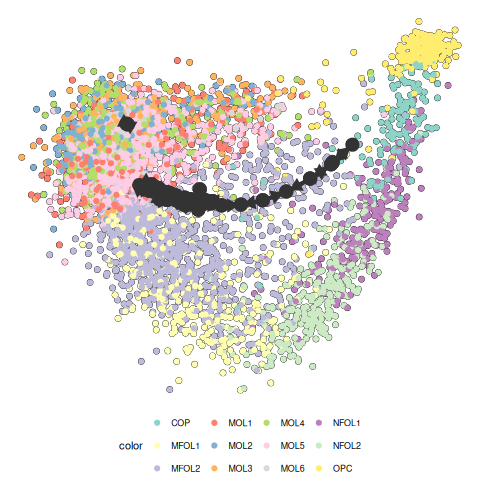

In [105]:
%%R
plot_dimred(paga_traj, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

In [121]:
%%R
paga_traj$milestone_network <- paga_traj$milestone_network[paga_traj$milestone_network$length != 0, ]
# paga_traj$milestone_network

In [181]:
%%R
paga_metrics <- calculate_metrics(
  dataset = paga_dataset,
  model = paga_traj,
  metrics = dyneval::metrics$metric_id,
  expression_source = paga_dataset$expression
)

In [123]:
%%R
cat("HIM =", paga_metrics$him, "\n")
cat("F1_branches =", paga_metrics$F1_branches, "\n")
cat("correlation =", paga_metrics$correlation, "\n")
cat("featureimp_wcor =", paga_metrics$featureimp_wcor, "\n")
paga_selected_metrics <- c(
  him = as.numeric(paga_metrics$him),
  F1_branches = paga_metrics$F1_branches,
  correlation = paga_metrics$correlation,
  featureimp_wcor = paga_metrics$featureimp_wcor
)
paga_overall_score <- exp(mean(log(paga_selected_metrics)))
cat("overall_score =", paga_overall_score, "\n")

HIM = 0.4782525 
F1_branches = 0.06924227 
correlation = 0.4385336 
featureimp_wcor = 0.7954567 
overall_score = 0.32784 


In [106]:
%%R
dataset$counts <- Matrix::Matrix(dataset$counts, sparse = TRUE)
dataset$expression <- Matrix::Matrix(dataset$expression, sparse = TRUE)

In [184]:
%%R
dpt_metrics <- calculate_metrics(
  dataset = dataset,
  model = dpt_model,
  metrics = dyneval::metrics$metric_id,
  expression_source = dataset$expression
)
cat("HIM =", dpt_metrics$him, "\n")
cat("F1_branches =", dpt_metrics$F1_branches, "\n")
cat("correlation =", dpt_metrics$correlation, "\n")
cat("featureimp_wcor =", dpt_metrics$featureimp_wcor, "\n")
dpt_selected_metrics <- c(
  him = as.numeric(dpt_metrics$him),
  F1_branches = dpt_metrics$F1_branches,
  correlation = dpt_metrics$correlation,
  featureimp_wcor = dpt_metrics$featureimp_wcor
)
dpt_overall_score <- exp(mean(log(dpt_selected_metrics)))
cat("overall_score =", dpt_overall_score, "\n")

HIM = 0.4488526 
F1_branches = 0.1662083 
correlation = 0.5499506 
featureimp_wcor = 0.7366212 
overall_score = 0.4169472 


In addition: Warning message:
In ks.test.default(sel, notsel, alternative = "greater") :
  p-value will be approximate in the presence of ties


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


You can run this method as an R wrapper (1, default) or as a container (2)
Which do you want to use? This option will be saved in options(dynwrap_backend = c('r_wrapper', 'container'))
1: R wrapper [default]
2: Container
Following packages have to be installed: tislingshot
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'tislingshot' from a github remote, the SHA1 (65248eca) has not changed since last install.
  Use `force = TRUE` to force installation


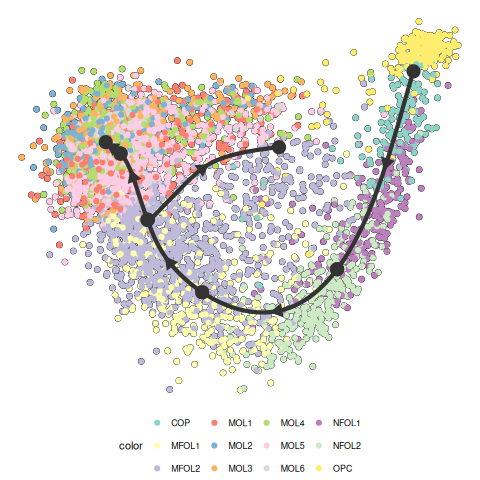

In [110]:
%%R
slingshot_model <- infer_trajectory(dataset, ti_slingshot(), give_priors = c("start_id"))
slingshot_model <- add_cell_waypoints(slingshot_model)
plot_dimred(slingshot_model, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

In [186]:
%%R
slingshot_metrics <- calculate_metrics(
  dataset = dataset,
  model = slingshot_model,
  metrics = dyneval::metrics$metric_id,
  expression_source = dataset$expression
)
cat("HIM =", slingshot_metrics$him, "\n")
cat("F1_branches =", slingshot_metrics$F1_branches, "\n")
cat("correlation =", slingshot_metrics$correlation, "\n")
cat("featureimp_wcor =", slingshot_metrics$featureimp_wcor, "\n")
slingshot_selected_metrics <- c(
  him = as.numeric(slingshot_metrics$him),
  F1_branches = slingshot_metrics$F1_branches,
  correlation = slingshot_metrics$correlation,
  featureimp_wcor = slingshot_metrics$featureimp_wcor
)
slingshot_overall_score <- exp(mean(log(slingshot_selected_metrics)))
cat("overall_score =", slingshot_overall_score, "\n")

HIM = 0.4316407 
F1_branches = 0.3000195 
correlation = 0.5643997 
featureimp_wcor = 0.889008 
overall_score = 0.5048834 


Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


Following packages have to be installed: SCORPIUS
Do you want to install these packages? 
1: Yes [default]
2: No
Skipping install of 'SCORPIUS' from a github remote, the SHA1 (a0a97907) has not changed since last install.
  Use `force = TRUE` to force installation


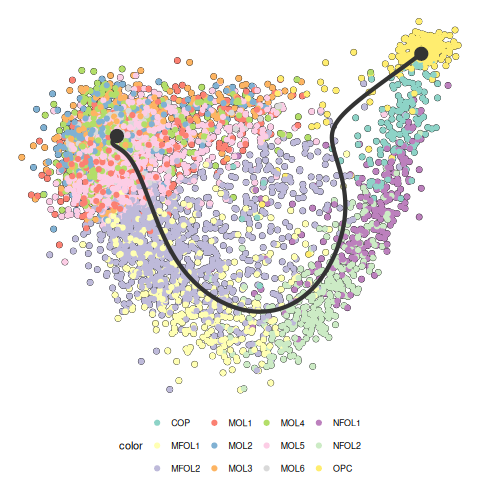

In [111]:
%%R
scorpius_model <- infer_trajectory(dataset, ti_scorpius(), give_priors = c("start_id"))
scorpius_model <- add_cell_waypoints(scorpius_model)
plot_dimred(scorpius_model, dimred=pca_dimred, color_cells = "grouping", grouping = groups) + scale_color_manual(values = palette)

In [187]:
%%R
scorpius_metrics <- calculate_metrics(
  dataset = dataset,
  model = scorpius_model,
  metrics = dyneval::metrics$metric_id,
  expression_source = dataset$expression
)
cat("HIM =", scorpius_metrics$him, "\n")
cat("F1_branches =", scorpius_metrics$F1_branches, "\n")
cat("correlation =", scorpius_metrics$correlation, "\n")
cat("featureimp_wcor =", scorpius_metrics$featureimp_wcor, "\n")
scorpius_selected_metrics <- c(
  him = as.numeric(scorpius_metrics$him),
  F1_branches = scorpius_metrics$F1_branches,
  correlation = scorpius_metrics$correlation,
  featureimp_wcor = scorpius_metrics$featureimp_wcor
)
scorpius_overall_score <- exp(mean(log(scorpius_selected_metrics)))
cat("overall_score =", scorpius_overall_score, "\n")

HIM = 0.2688911 
F1_branches = 0.2162375 
correlation = 0.622388 
featureimp_wcor = 0.7455442 
overall_score = 0.405285 


In addition: Warning message:
In ks.test.default(sel, notsel, alternative = "greater") :
  p-value will be approximate in the presence of ties


In [ ]:
%%R -o via_metrics -o marg_metrics -o pal_metrics -o paga_metrics -o dpt_metrics -o slingshot_metrics -o scorpius_metrics
print('outputs')

[1] "outputs"


In [ ]:
# List of dataframes to combine
dataframes = [
    via_metrics, marg_metrics, pal_metrics, paga_metrics, dpt_metrics, slingshot_metrics, scorpius_metrics
]

# Find all unique columns across all dataframes
all_columns = set().union(*(df.columns for df in dataframes))

# Ensure all dataframes have the same columns, filling missing ones with 0
aligned_dataframes = [
    df.reindex(columns=all_columns, fill_value=0) if df is pal_metrics else df
    for df in dataframes
]

# Combine all dataframes
combined_metrics = pd.concat(aligned_dataframes, ignore_index=True)
combined_metrics.index = ['Via', 'Margaret', 'Palantir', 'PAGA', 'DPT', 'Slingshot', 'Scorpius']

In [10]:
combined_metrics.to_csv("combined_metrics_oligodendrocyte.csv", index=True)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

combined_metrics = pd.read_csv("combined_metrics_oligodendrocyte.csv", index_col=0)
combined_metrics

correlation  edge_flip       him  isomorphic    rf_mse   rf_nmse  \
Via           0.622446        0.0  0.463102         0.0  0.056231  0.396226   
Margaret      0.433527        0.0  0.520855         0.0  0.057703  0.380416   
Palantir      0.000000        0.0  0.268891         0.0  0.058767  0.368999   
PAGA          0.438534        0.0  0.478252         0.0  0.053025  0.430650   
DPT           0.549951        0.5  0.448853         0.0  0.071165  0.235878   
Slingshot     0.564400        0.5  0.431641         0.0  0.054144  0.418638   
Scorpius      0.622388        0.0  0.268891         0.0  0.070377  0.244336   

             rf_rsq   lm_nmse    lm_mse    lm_rsq  ...  \
Via        0.362073  0.397975  0.056068  0.365353  ...   
Margaret   0.340198  0.387413  0.057052  0.346842  ...   
Palantir   0.307472  0.170013  0.077299  0.143254  ...   
PAGA       0.388343  0.425067  0.053545  0.382194  ...   
DPT        0.202462  0.182995  0.076090  0.163624  ...   
Slingshot  0.350998  0.273822  0.067631  0.241201  ...   
Scorpius   0.152287  0.127234  0.081283  0.131432  ...   

           time_waypointedgeodesic  time_correlation  time_edge_flip  \
Via                       4.550772          0.172501        0.074710   
Margaret                  2.788554          0.189734        0.068473   
Palantir                  0.000000          0.000000        0.058906   
PAGA                      3.701565          0.190362        0.113510   
DPT                       9.425129          0.666710        0.055634   
Slingshot                 6.295602          0.551141        0.072825   
Scorpius                 12.093508          0.582162        0.040483   

           time_him  time_isomorphic     time_pp  time_featureimp  \
Via        0.072055         0.000093   74.631276       174.115151   
Margaret   0.068767         0.000124   51.749665       153.315234   
Palantir   0.065509         0.000903   78.747387        99.865078   
PAGA       0.218101         0.000224  116.345818       217.128690   
DPT        0.040193         0.000115   45.577410        67.252108   
Slingshot  0.038568         0.000094   37.389779        73.793329   
Scorpius   0.039568         0.000108   65.980088        58.062200   

           time_featureimp_enrichment  time_mapping_branches  \
Via                        117.999061               0.982232   
Margaret                    97.947162               1.798148   
Palantir                    33.619061               0.976115   
PAGA                       162.797601               1.098864   
DPT                         20.790356               0.918756   
Slingshot                   28.635680               0.893076   
Scorpius                    14.087551               0.883127   

           time_mapping_milestones  
Via                       0.939068  
Margaret                  1.148614  
Palantir                  0.913993  
PAGA                      1.027589  
DPT                       0.873473  
Slingshot                 0.883025  
Scorpius                  0.864810  

[7 rows x 30 columns]

In [2]:
from scipy.stats import gmean

selected_metrics = combined_metrics[['him', 'F1_branches', 'correlation', 'featureimp_wcor']].copy()
selected_metrics.loc['Palantir', 'correlation'] = selected_metrics[selected_metrics.index != 'Palantir']['correlation'].mean()
selected_metrics['Overall Score'] = selected_metrics.apply(gmean, axis=1)
selected_metrics.rename(columns={'him': 'HIM', 'correlation': 'Correlation', 'featureimp_wcor': 'Featureimp_wcor'}, inplace=True)
selected_metrics

HIM  F1_branches  Correlation  Featureimp_wcor  Overall Score
Via        0.463102     0.070348     0.622446         0.809636       0.357957
Margaret   0.520855     0.101490     0.433527         0.845117       0.373051
Palantir   0.268891     0.332129     0.538541         0.724965       0.432120
PAGA       0.478252     0.069242     0.438534         0.813888       0.329723
DPT        0.448853     0.166208     0.549951         0.736621       0.416947
Slingshot  0.431641     0.300019     0.564400         0.889008       0.504883
Scorpius   0.268891     0.216238     0.622388         0.745544       0.405285

In [3]:
# Identify columns that start with 'time_'
time_columns = [col for col in combined_metrics.columns if col.startswith('time_')]

# Identify other columns
other_columns = [col for col in combined_metrics.columns if not col.startswith('time_')]

# Reorder the columns
reordered_columns = other_columns + time_columns

# Reorder the DataFrame
combined_metrics = combined_metrics[reordered_columns]
combined_metrics

correlation  edge_flip       him  isomorphic    rf_mse   rf_nmse  \
Via           0.622446        0.0  0.463102         0.0  0.056231  0.396226   
Margaret      0.433527        0.0  0.520855         0.0  0.057703  0.380416   
Palantir      0.000000        0.0  0.268891         0.0  0.058767  0.368999   
PAGA          0.438534        0.0  0.478252         0.0  0.053025  0.430650   
DPT           0.549951        0.5  0.448853         0.0  0.071165  0.235878   
Slingshot     0.564400        0.5  0.431641         0.0  0.054144  0.418638   
Scorpius      0.622388        0.0  0.268891         0.0  0.070377  0.244336   

             rf_rsq   lm_nmse    lm_mse    lm_rsq  ...  \
Via        0.362073  0.397975  0.056068  0.365353  ...   
Margaret   0.340198  0.387413  0.057052  0.346842  ...   
Palantir   0.307472  0.170013  0.077299  0.143254  ...   
PAGA       0.388343  0.425067  0.053545  0.382194  ...   
DPT        0.202462  0.182995  0.076090  0.163624  ...   
Slingshot  0.350998  0.273822  0.067631  0.241201  ...   
Scorpius   0.152287  0.127234  0.081283  0.131432  ...   

           time_waypointedgeodesic  time_correlation  time_edge_flip  \
Via                       4.550772          0.172501        0.074710   
Margaret                  2.788554          0.189734        0.068473   
Palantir                  0.000000          0.000000        0.058906   
PAGA                      3.701565          0.190362        0.113510   
DPT                       9.425129          0.666710        0.055634   
Slingshot                 6.295602          0.551141        0.072825   
Scorpius                 12.093508          0.582162        0.040483   

           time_him  time_isomorphic     time_pp  time_featureimp  \
Via        0.072055         0.000093   74.631276       174.115151   
Margaret   0.068767         0.000124   51.749665       153.315234   
Palantir   0.065509         0.000903   78.747387        99.865078   
PAGA       0.218101         0.000224  116.345818       217.128690   
DPT        0.040193         0.000115   45.577410        67.252108   
Slingshot  0.038568         0.000094   37.389779        73.793329   
Scorpius   0.039568         0.000108   65.980088        58.062200   

           time_featureimp_enrichment  time_mapping_branches  \
Via                        117.999061               0.982232   
Margaret                    97.947162               1.798148   
Palantir                    33.619061               0.976115   
PAGA                       162.797601               1.098864   
DPT                         20.790356               0.918756   
Slingshot                   28.635680               0.893076   
Scorpius                    14.087551               0.883127   

           time_mapping_milestones  
Via                       0.939068  
Margaret                  1.148614  
Palantir                  0.913993  
PAGA                      1.027589  
DPT                       0.873473  
Slingshot                 0.883025  
Scorpius                  0.864810  

[7 rows x 30 columns]

In [4]:
# Normalize only time metrics
normalized_metrics = combined_metrics.copy()
normalized_metrics[time_columns] = combined_metrics[time_columns].div(combined_metrics[time_columns].max(axis=0), axis=1)
normalized_metrics

correlation  edge_flip       him  isomorphic    rf_mse   rf_nmse  \
Via           0.622446        0.0  0.463102         0.0  0.056231  0.396226   
Margaret      0.433527        0.0  0.520855         0.0  0.057703  0.380416   
Palantir      0.000000        0.0  0.268891         0.0  0.058767  0.368999   
PAGA          0.438534        0.0  0.478252         0.0  0.053025  0.430650   
DPT           0.549951        0.5  0.448853         0.0  0.071165  0.235878   
Slingshot     0.564400        0.5  0.431641         0.0  0.054144  0.418638   
Scorpius      0.622388        0.0  0.268891         0.0  0.070377  0.244336   

             rf_rsq   lm_nmse    lm_mse    lm_rsq  ...  \
Via        0.362073  0.397975  0.056068  0.365353  ...   
Margaret   0.340198  0.387413  0.057052  0.346842  ...   
Palantir   0.307472  0.170013  0.077299  0.143254  ...   
PAGA       0.388343  0.425067  0.053545  0.382194  ...   
DPT        0.202462  0.182995  0.076090  0.163624  ...   
Slingshot  0.350998  0.273822  0.067631  0.241201  ...   
Scorpius   0.152287  0.127234  0.081283  0.131432  ...   

           time_waypointedgeodesic  time_correlation  time_edge_flip  \
Via                       0.376299          0.258734        0.658178   
Margaret                  0.230583          0.284582        0.603229   
Palantir                  0.000000          0.000000        0.518950   
PAGA                      0.306079          0.285524        1.000000   
DPT                       0.779354          1.000000        0.490122   
Slingshot                 0.520577          0.826657        0.641576   
Scorpius                  1.000000          0.873186        0.356651   

           time_him  time_isomorphic   time_pp  time_featureimp  \
Via        0.330375         0.103539  0.641461         0.801898   
Margaret   0.315297         0.137084  0.444792         0.706103   
Palantir   0.300362         1.000000  0.676839         0.459935   
PAGA       1.000000         0.248547  1.000000         1.000000   
DPT        0.184287         0.127575  0.391741         0.309734   
Slingshot  0.176837         0.104596  0.321368         0.339860   
Scorpius   0.181423         0.119123  0.567103         0.267409   

           time_featureimp_enrichment  time_mapping_branches  \
Via                          0.724821               0.546247   
Margaret                     0.601650               1.000000   
Palantir                     0.206508               0.542845   
PAGA                         1.000000               0.611109   
DPT                          0.127707               0.510946   
Slingshot                    0.175897               0.496664   
Scorpius                     0.086534               0.491132   

           time_mapping_milestones  
Via                       0.817566  
Margaret                  1.000000  
Palantir                  0.795736  
PAGA                      0.894634  
DPT                       0.760459  
Slingshot                 0.768775  
Scorpius                  0.752916  

[7 rows x 30 columns]

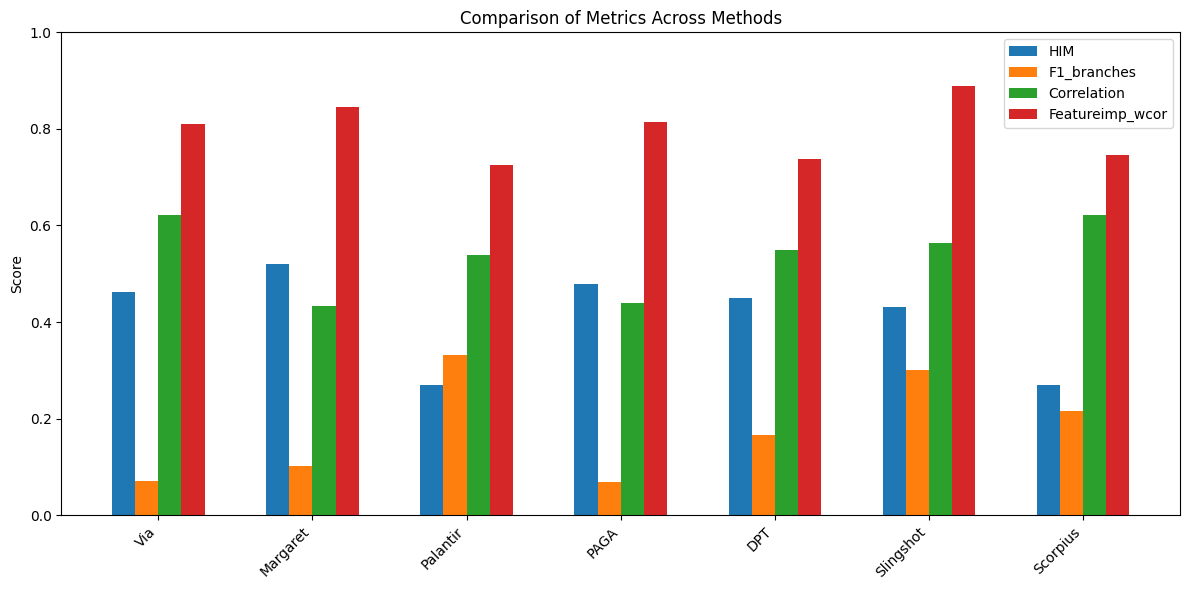

In [5]:
import pandas as pd

import matplotlib.pyplot as plt

# Assuming `metrics` is already defined as a DataFrame
columns_to_plot = ['HIM', 'F1_branches', 'Correlation', 'Featureimp_wcor']
methods = selected_metrics.index

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(12, 6))

# Create the bar plot
bar_width = 0.15
x = range(len(methods))

for i, column in enumerate(columns_to_plot):
    ax.bar(
        [pos + i * bar_width for pos in x],
        selected_metrics[column],
        bar_width,
        label=column
    )

# Set x-axis labels and ticks
ax.set_xticks([pos + (len(columns_to_plot) - 1) * bar_width / 2 for pos in x])
ax.set_xticklabels(methods, rotation=45, ha='right')

# Set y-axis limits
ax.set_ylim(0, 1)

# Add labels and legend
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics Across Methods')
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()

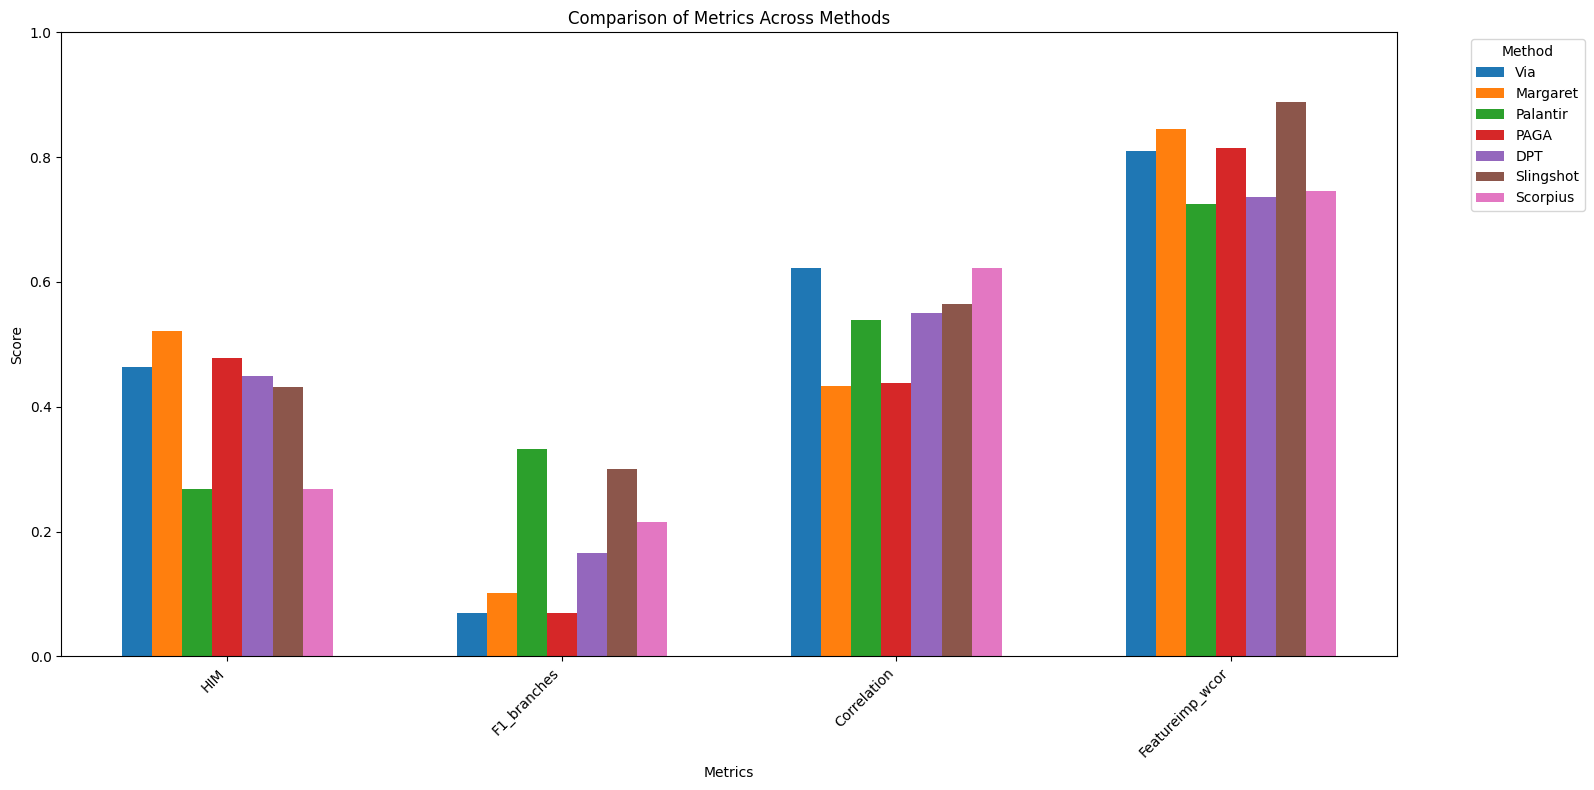

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Selected metrics (without Overall Score)
columns_to_plot = ['HIM', 'F1_branches', 'Correlation', 'Featureimp_wcor']
metrics_df = selected_metrics[columns_to_plot]

# Methods (DataFrame index)
methods = metrics_df.index.tolist()
n_metrics = len(columns_to_plot)
n_methods = len(methods)

# Create x positions for metric groups
x = np.arange(n_metrics)

# Adjust the bar width and figure size; here we use a slightly smaller width and larger figure
bar_width = 0.09

fig, ax = plt.subplots(figsize=(16, 8))

for i, method in enumerate(methods):
    ax.bar(x + i * bar_width,
           metrics_df.loc[method].values,
           bar_width,
           label=method)

# Center the x-axis ticks within each group
ax.set_xticks(x + (n_methods - 1) * bar_width / 2)
ax.set_xticklabels(columns_to_plot, rotation=45, ha='right')

ax.set_ylim(0, 1)
ax.set_xlabel('Metrics')
ax.set_ylabel('Score')
ax.set_title('Comparison of Metrics Across Methods')

# Place the legend outside the plot for clarity
ax.legend(title='Method', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


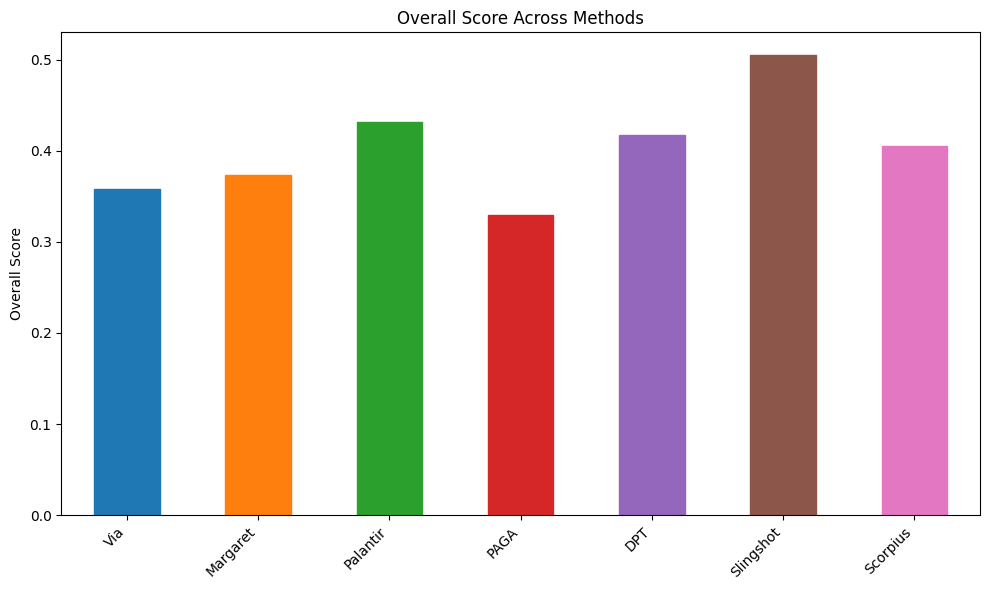

In [7]:
# Plot the Overall Score
plt.figure(figsize=(10, 6))
selected_metrics['Overall Score'].plot(kind='bar', color='skyblue', edgecolor='black')

# Add labels and title
plt.ylabel('Overall Score')
plt.title('Overall Score Across Methods')
plt.xticks(rotation=45, ha='right')
# Assign the same colors to the bars as in the plot above
colors = plt.cm.tab10(range(len(selected_metrics)))
for bar, color in zip(plt.gca().patches, colors):
    bar.set_color(color)
# Show the plot
plt.tight_layout()
plt.show()

In [8]:
selected_metrics.to_csv("selected_metrics_oligodendrocyte.csv", index=True)

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

selected_metrics = pd.read_csv("selected_metrics_oligodendrocyte.csv", index_col=0)
selected_metrics

HIM  F1_branches  Correlation  Featureimp_wcor  Overall Score
Via        0.463102     0.070348     0.622446         0.809636       0.357957
Margaret   0.520855     0.101490     0.433527         0.845117       0.373051
Palantir   0.268891     0.332129     0.538541         0.724965       0.432120
PAGA       0.478252     0.069242     0.438534         0.813888       0.329723
DPT        0.448853     0.166208     0.549951         0.736621       0.416947
Slingshot  0.431641     0.300019     0.564400         0.889008       0.504883
Scorpius   0.268891     0.216238     0.622388         0.745544       0.405285